# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**План работ:**
1. Откроем датасет и изучим общую информацию
2. Выполним предобработку данных
    - Обработаем пропуски
    - Преобразуем типы данных
    - Устраним дубликаты
    - Устраним редкие и выбивающиеся значения
3. Добавим новые столбцы
4. Изучим данные
    - Построим распределение параметров
    - Изучим как быстро продавались квартиры
    - Проверим, какие факторы влияют на стоимость объекта
    - Найдем населённые пункты с самой высокой и самой низкой ценой квадратного метра
5. Сформируем вывод


In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# установим настройки графиков
from pylab import rcParams
#rcParams['figure.figsize'] = 20, 9
rcParams.update({
    'font.size': 14,
    'figure.figsize': (20, 9)
})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [2]:
# определим вспомогательные функции

# для построения гистограммы с медианой
def plot_histogram(x, bins=50, plt_range=None, grid=True, 
                   median=True, title=None, xlabel=None, ylabel='Кол-во объявлений'):
    '''
    Функция принимает pandas series и строит гистограмму c с медианой
    '''
    if title == None:
        title = x.name
    x.plot(kind='hist', grid=True, bins=bins, range=plt_range)
    if median:
        plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1, label='Median')
        plt.legend()
    plt.title(title, fontsize=22, color='SteelBlue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
# для подсчёта пропусков
def count_na(data):
    return data.isna().sum()

In [3]:
# создадим словарь с описанием названий столбцов
column_names_dict = {
    'total_images': 'Количество фотографий', 
    'last_price': 'Цена, ₽', 
    'total_area': 'Площадь, кв. м.', 
    'first_day_exposition': 'Дата публикации',       
    'rooms': 'Количество комнат', 
    'ceiling_height': 'Высота потолков, м.', 
    'floors_total': 'Количество этажей', 
    'living_area': 'Жилая площадь, кв. м.', 
    'floor': 'Этаж',       
    'is_apartment': 'Аппартаменты', 
    'studio': 'Студия', 
    'open_plan': 'Свободная планировка', 
    'kitchen_area': 'Площадь кухни, кв. м.', 
    'balcony': 'Количество балконов',
    'locality_name': 'Название населённого пункта', 
    'airports_nearest': 'Расстояние до ближайшего аэропорта, м.', 
    'cityCenters_nearest': 'Расстояние до центра города, м.',
    'parks_around3000': 'Парки в пределах 3-х км.', 
    'parks_nearest': 'Расстояние до ближайшего парка, м.', 
    'ponds_around3000': 'Пруды в пределах 3-х км.',       
    'ponds_nearest': 'Расстояние до ближайшего пруда, м.', 
    'days_exposition': 'Дней публикации', 
    'new_loacality_name': 'Название населённого пункта',
    'one_sqr_meter_price': 'Цена квадратного метра', 
    'day_of_week': 'День недели', 
    'month': 'Месяц', 
    'year': 'Год', 
    'floor_type': 'Тип этажа',
    'cityCenters_nearest_km': 'Расстояние до центра города, км.'
}

### Откроем файл с данными и изучим общую информацию. 

In [4]:
# прочитаем датасет
try:
    df = pd.read_csv('real_estate_data.csv')
except:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 

In [5]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [6]:
# выведем информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Построим гистограмму

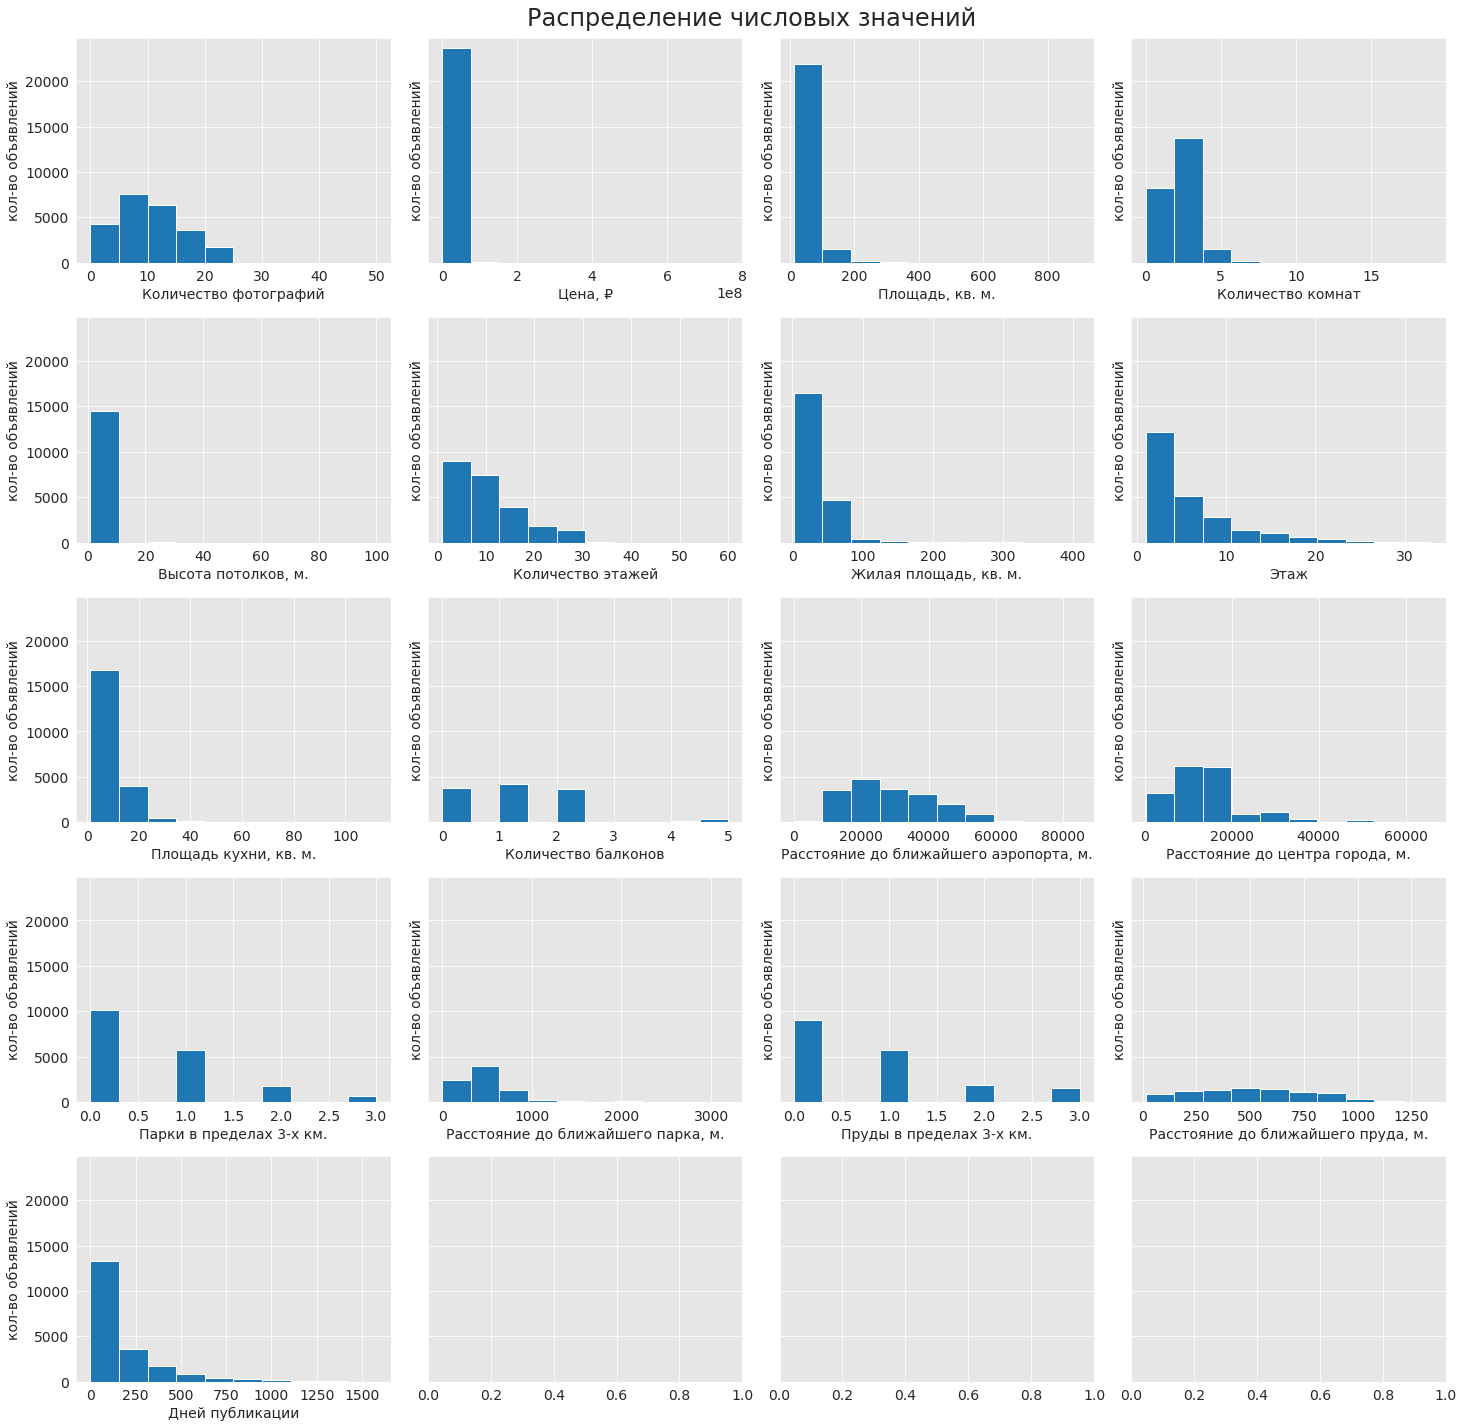

In [7]:
# выберм список столбцов с числовым типом
numeric_columns = df.select_dtypes(include='number').columns

# зададим количество столбцов и рассчитаем количество строк
ncols = 4
nrows = math.ceil(len(numeric_columns) / ncols)

# построим график
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharey=True)
fig.suptitle('Распределение числовых значений', fontsize=24)
fig.tight_layout(h_pad=2)

for idx, feat in  enumerate(numeric_columns):
    axes[idx // ncols, idx % ncols].hist(df[feat])
    axes[idx // ncols, idx % ncols].set_xlabel(column_names_dict[feat])
    axes[idx // ncols, idx % ncols].set_ylabel('кол-во объявлений')
    #break


### Предобработка данных

#### Найдём и изучим пропущенные значения в столбцах

In [8]:
# проверим количество пропусков, отсортируем по убыванию
df.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [1]:
# пропущенные значения бары

def pass_value_barh(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
        .set_title('Процент пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
    );    

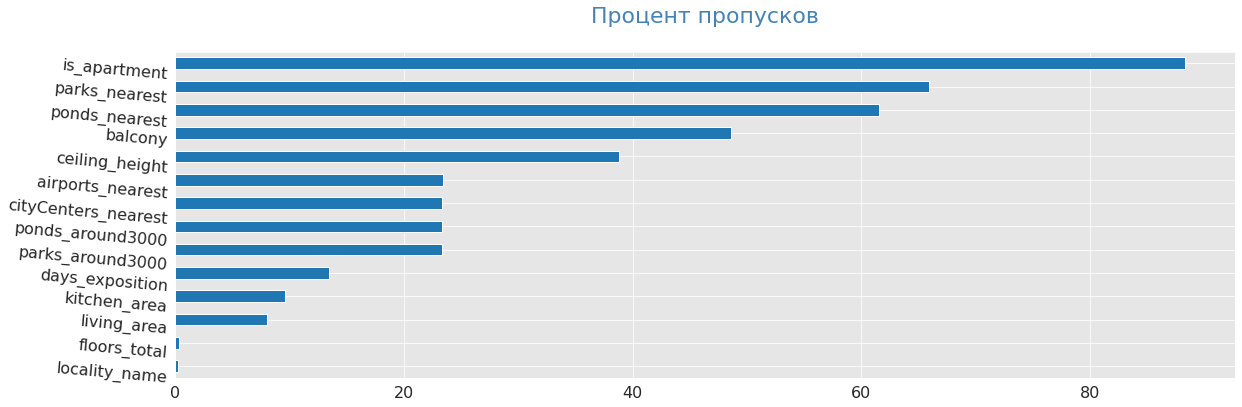

In [10]:
pass_value_barh(df)

##### Обработаем пропуски в столбце is_apartment

In [11]:
count_na(df['is_apartment'])

20924

is_apartment показывает, является ли объект апартаментами. С большой вероятностью, поле могло быть не заполнено для обычных квартир. Логично будет указать значение False для пропусков

In [12]:
# заполним пропуски в столбце is_apartment значениями False
df['is_apartment'].fillna(False, inplace=True)

##### Обработае пропуски в стобцах parks_nearest и ponds_nearest

Возможны несколько причин пропусков:
- автор объявления не посчитал нужным указать
- ближайший парк или пруд находится очень далеко
- ошибка при выгрузке данных

Проверим, есть ли парки и пруды в радиусе 3-х километров для строк с пропусками
Проверим, есть ли обьекты с пропусками в parks_nearest с parks_around3000 больше нуля. Сде и ponds_nearest со значениями parks_around3000 ponds_around3000

In [13]:
# Проверим, есть ли обьекты с пропусками в parks_nearest с parks_around3000 больше нуля
df[(df['parks_nearest'].isna()) & (df['parks_around3000'] > 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [14]:
# Проверим, есть ли обьекты с пропусками в ponds_nearest с ponds_around3000 больше нуля
df[(df['ponds_nearest'].isna()) & (df['ponds_around3000'] > 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [15]:
# ради интереса, посчитаем  количество пропусков в parks_nearest и ponds_nearest по населённым пунктам
# выведем топ-10
(df[df['parks_nearest'].isna() | df['ponds_nearest'].isna()]
 .groupby('locality_name')['locality_name']
 .count().sort_values(ascending=False).head(10))

locality_name
Санкт-Петербург      11461
посёлок Мурино         522
посёлок Шушары         440
Всеволожск             398
посёлок Парголово      317
Гатчина                307
деревня Кудрово        299
Колпино                270
Выборг                 237
Пушкин                 236
Name: locality_name, dtype: int64

Действительно для строк с пропусками нет парков или прудов в радиусе 3-х километров.
При наличии адреса или координат объекта можно было бы найти расстояние.
Так как у нас большое количество пропусков и их заполнение может повлиять на распределение, оставим пропуски незаполненными

##### Обработаем пропуски в столбце balcony

In [16]:
# проверим поличество пропусков
count_na(df['balcony'])

11519

В столбце balcony данные могли быть не указаны для квартир без балконов. Заполним пропуски нулями

In [17]:
# Заполним пропуски в столбце balcony нулями
df['balcony'].fillna(0, inplace=True)

##### Обработаем пропуски в столбце ceiling_height

In [18]:
count_na(df['ceiling_height'])

9195

In [19]:
# ради интереса, посчитаем  количество пропусков в ceiling_height в зависимости от населённого пункта
# выведем топ-10 результатов
(df[df['ceiling_height'].isna()]
 .groupby('locality_name')['locality_name']
 .count().sort_values(ascending=False).head(10))

locality_name
Санкт-Петербург      5617
посёлок Мурино        322
посёлок Шушары        223
посёлок Парголово     190
деревня Кудрово       177
Гатчина               158
Выборг                139
Пушкин                135
Колпино               135
Всеволожск            126
Name: locality_name, dtype: int64

ceiling_height вероятно не была заполнена автором, так как он посчитал, что эта величина стандартная
Так как, пропусков много, чтобы не повлиять на распределение, оставим их пустыми

##### обработаем пропуски в столбце airports_nearest

In [20]:
# проверим поличество пропусков
count_na(df['airports_nearest'])

5542

airports_nearest мог быть не заполнен, если ближайщий аэропорт находится очень далеко.
Пропуски можно заполнить медианной в зависимости от населённого пункта.
Для начала посмотрим, как распределятся количество пропусков в зависимости от населённого пункта. по каким населенным пунктам получиться найти медиану

In [21]:
# ради интереса, посчитаем  количество пропусков в airports_nearest в зависимости от населённого пункта
# выведем топ-20 результатов
(df[df['airports_nearest'].isna()]
 .groupby('locality_name')['locality_name']
 .count().sort_values(ascending=False).head(20))

locality_name
посёлок Мурино             522
Всеволожск                 398
Гатчина                    307
деревня Кудрово            299
Выборг                     237
Кудрово                    173
деревня Новое Девяткино    144
Сертолово                  142
Кириши                     125
Сланцы                     112
Волхов                     111
Кингисепп                  104
Тосно                      104
Никольское                  93
Коммунар                    89
Сосновый Бор                87
Санкт-Петербург             85
Кировск                     84
Отрадное                    80
посёлок Бугры               69
Name: locality_name, dtype: int64

In [22]:
# проверим, для каких населённых пунктов удасться посчитать медиану
# отсортируем  результат и выведем 30 строк
df.groupby('locality_name')['airports_nearest'].median().sort_values().head(30)

locality_name
посёлок Александровская    12896.5
Пушкин                     15766.0
посёлок Шушары             17427.0
Павловск                   20529.5
посёлок Петро-Славянка     20605.0
Красное Село               25715.5
посёлок Металлострой       25758.0
Колпино                    26232.0
посёлок Усть-Ижора         26510.5
Санкт-Петербург            26757.5
посёлок Стрельна           28317.0
посёлок Понтонный          30642.0
посёлок Сапёрный           34147.5
Петергоф                   39231.0
Ломоносов                  48415.5
поселок Мурино             51553.0
посёлок Левашово           52693.0
посёлок Парголово          53426.0
посёлок Песочный           54831.5
посёлок Лисий Нос          54988.5
поселок Лисий Нос          55930.0
Сестрорецк                 56692.0
посёлок Белоостров         57769.0
посёлок Репино             61797.5
посёлок Щеглово            61908.0
Кронштадт                  67850.0
Зеленогорск                72282.0
посёлок Молодёжное         84665.0
Боксит

In [23]:
df.locality_name.nunique()

364

Видим, что у нас есть данные по расстоянию до аэропорта только для 28 населённых пунтов из 364. Заполним таким образом все пропуски, которые сможем
Остальные пропуски оставим как есть, чтобы не искажать распределение

In [24]:
df['airports_nearest'].fillna(df.groupby('locality_name')['airports_nearest'].transform('median'), 
                              inplace=True)

In [25]:
# проверим, сколько пропусков осталось
count_na(df['airports_nearest'])

5394

##### обработаем пропуски в столбце cityCenters_nearest

In [26]:
# выведем количество пропусков
count_na(df['cityCenters_nearest'])

5519

Для расстояния до центра города ситуация аналогичная. 
К сожалению, адрес или координаты объектов мы не знаем, поэтому вычислить расстояние мы не сможем.
Поверим, как распределяется расстояние до центра в Санкт-Петербурге

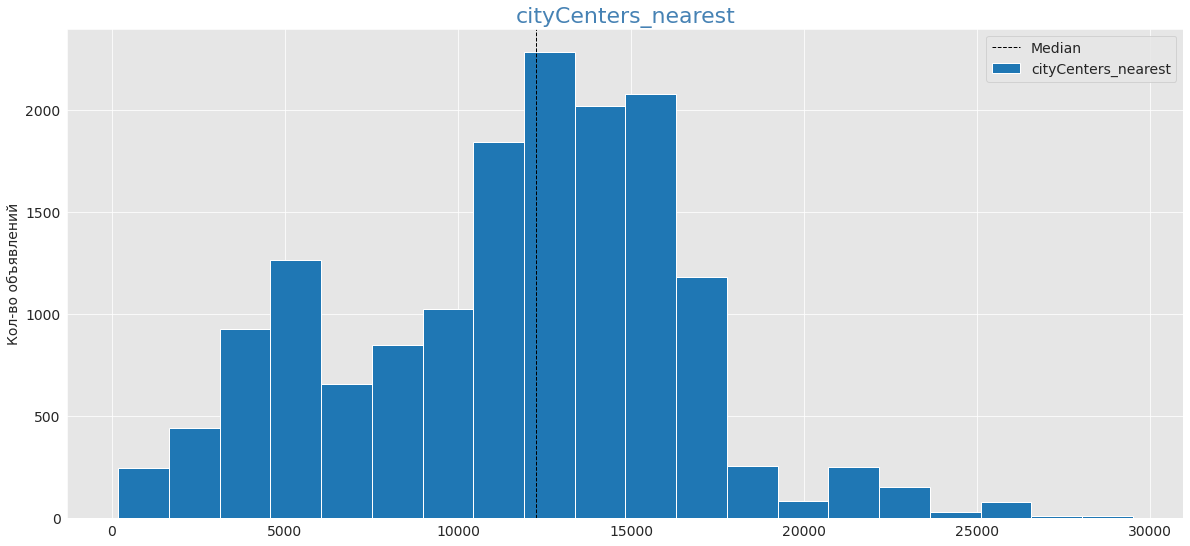

In [27]:
plot_histogram(df[df['locality_name'] == 'Санкт-Петербург']['cityCenters_nearest'], bins = 20)

Не совсем понятно, расстояние до центра чего именно обозначает столбец cityCenters_nearest.
Есть 2 варианта:
1. До центра Санкт-Петербурка
2. До центра населённого пункта

Чтобы понять, проверим минимальное расстояние до центра для каждого населенного пункта.

In [28]:
# сгруппируем датасет по locality_name найдём минимальное значение cityCenters_nearest
# резульат отсортируем по возрастанию и выведем 30 верхних строк
df.groupby('locality_name')['cityCenters_nearest'].min().sort_values().head(30)

locality_name
Санкт-Петербург              181.0
посёлок Шушары             17012.0
посёлок Парголово          17994.0
посёлок Стрельна           21813.0
поселок Мурино             21888.0
Пушкин                     24311.0
посёлок Левашово           25727.0
посёлок Песочный           25867.0
посёлок Лисий Нос          26368.0
посёлок Металлострой       26696.0
посёлок Петро-Славянка     27165.0
Красное Село               27317.0
посёлок Александровская    27352.0
посёлок Усть-Ижора         28212.0
поселок Лисий Нос          28246.0
Колпино                    29436.0
Петергоф                   29815.0
посёлок Понтонный          30709.0
Сестрорецк                 31130.0
Павловск                   31533.0
посёлок Щеглово            34085.0
посёлок Сапёрный           35822.0
Ломоносов                  36816.0
посёлок Белоостров         38868.0
посёлок Репино             42550.0
Кронштадт                  46657.0
Зеленогорск                51115.0
посёлок Молодёжное         64857.0
Боксит

In [29]:
# ради интереса, посчитаем  количество пропусков в cityCenters_nearest в зависимости от населённого пункта
# выведем топ-20 результатов
(df[df['cityCenters_nearest'].isna()]
 .groupby('locality_name')['locality_name']
 .count().sort_values(ascending=False).head(20))

locality_name
посёлок Мурино             522
Всеволожск                 398
Гатчина                    307
деревня Кудрово            299
Выборг                     237
Кудрово                    173
деревня Новое Девяткино    144
Сертолово                  142
Кириши                     125
Сланцы                     112
Волхов                     111
Тосно                      104
Кингисепп                  104
Никольское                  93
Коммунар                    89
Сосновый Бор                87
Кировск                     84
Отрадное                    80
посёлок Бугры               69
Приозерск                   66
Name: locality_name, dtype: int64

Видим, что большая часть пропусков приходится на небольшие населённые пункты.
Зполним пропуски медианой для соответствующего населённого пункта(если её можно вычислить). 

In [30]:
df['cityCenters_nearest'].fillna(df.groupby('locality_name')['cityCenters_nearest'].transform('median'), 
                              inplace=True)

In [31]:
# проверим сколько пропусков осталось
count_na(df['cityCenters_nearest'])

5394

##### Обработаем пропуски в столбцах ponds_around3000 и ponds_around3000

In [32]:
# выведем количество пропусков
print(count_na(df['parks_around3000']))
print(count_na(df['ponds_around3000']))

5518
5518


Предположим, что пропуск может означать, что парков или прудов в радиусе 3-х километров нет.
Проверим, так ли это.

In [33]:
# Выведем строки с пропусками в parks_around3000 и значением в parks_nearest не более 3000
df[(df['parks_around3000'].isna()) & (df['parks_nearest'] <= 3000)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [34]:
# Выведем строки с пропусками в ponds_around3000 и значением в ponds_nearest не более 3000
df[(df['ponds_around3000'].isna()) & (df['ponds_nearest'] <= 3000)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Таких столбцов нет, заполним пропуски нулями

In [35]:
df['parks_around3000'].fillna(0, inplace=True)
df['ponds_around3000'].fillna(0, inplace=True)

##### Рассмотрим пропуски в days_exposition

In [36]:
count_na(df['days_exposition'])

3181

Можно предположить что пропуски означают, что объявление было снято с публикации тот же день, также есть большая вероятность ошибки.
Так как у нас столбца сдатой снятия с публикации нет, оставим пропуски как есть, чтобы не влиять на распределение

##### Обработаем пропуски в kitchen_area

In [37]:
# выведем количество пропусков
count_na(df['kitchen_area'])

2278

обявления с пропусками в столбце kitchen_area могут быть апартаментами или квартирами со свободной планировкой. Проверим это

In [38]:
# отфильтруем апартаменты и квартиры со свободной планировкой, проверим количество пропусков в kitchen_area
df[df['is_apartment'] | df['open_plan'] | df['studio']]['kitchen_area'].isna().sum()

231

На апартаменты,студии и квартиры со свободной планировкой пришлось только 231 пропуска. 
Вторая версия -- это могут быть деревенские дома или дачи

In [39]:
# отфильтруем строки с пропусками в kitchen_area, сгруппируем по locality_name, 
# почситаем количество и отсортируем по убыванию

(df[df['kitchen_area'].isna()]
 .groupby('locality_name')['locality_name']
 .count().sort_values(ascending=False)).head(19)

locality_name
Санкт-Петербург      1379
посёлок Мурино        100
деревня Кудрово        68
посёлок Шушары         42
Всеволожск             41
посёлок Парголово      38
Выборг                 36
Пушкин                 31
Никольское             30
Кингисепп              29
Кириши                 17
Сланцы                 16
Сосновый Бор           16
Колпино                16
Кудрово                15
Сестрорецк             15
Волхов                 14
Луга                   13
Гатчина                13
Name: locality_name, dtype: int64

Эта версия, не подтвердилась, большинство таких объектов приходится на Санкт-Петербург, 

восстановить площадь кухни из total_area и living_area будет не совсем корректно, так как нам не известна площадь санузла.
Одним из объяснений может быть, то, что объект является комнатой в коммунальной квартире.

В апартаментах и студиях кухни может не быть, заполним пропуски нулями. 

Для объектов со свободной планировкой размер кухни не определён, логичнее будет не заполнять.
Для остальных объектов оставим без изменений


In [40]:
# отфильтруем апартаменты и студии с пустыми значениями в столбце kitchen_area
# присвоим им нули

df.loc[(df['is_apartment'] | df['studio'])
  & (df['kitchen_area'].isna()), 'kitchen_area'] = 0

##### Обработаем пропуски в living_area

In [41]:
# выведем количество пропусков
count_na(df['living_area'])

1903

Для апартаментов и студий жилая площадь должна быть.
Пропуски могут быть обусловлены тем, что у квартиры свободная планировка.
Найдем такие квартиры

In [42]:
df.loc[(df['open_plan'])
  & (df['living_area'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
780,9,2600000.0,26.1,2018-02-20T00:00:00,0,NaN,18.0,NaN,8,False,...,NaN,1.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,45.0
5749,20,3590000.0,25.0,2017-08-30T00:00:00,0,2.80,35.0,NaN,26,False,...,NaN,2.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,198.0
7818,11,3300000.0,27.3,2018-04-06T00:00:00,0,NaN,20.0,NaN,9,False,...,NaN,2.0,Санкт-Петербург,15990.0,13853.0,0.0,NaN,1.0,584.0,31.0
17783,3,48763000.0,157.0,2016-04-01T00:00:00,5,NaN,11.0,NaN,5,False,...,NaN,0.0,Санкт-Петербург,28399.0,7101.0,2.0,290.0,3.0,221.0,90.0
19392,5,71000000.0,371.0,2018-07-26T00:00:00,0,3.57,7.0,NaN,6,False,...,NaN,0.0,Санкт-Петербург,25257.0,6060.0,1.0,761.0,1.0,584.0,90.0


Для объектов со свободной планировкой размер жилой площади не определён, оставим как есть.
Так как мы не знаем площадь санузла, заполнять пропуски разностью total_area и living_area будет не совсем корректно.
Заполнять медианой не будем, чтобы не влиять на распределение

##### Обработаем пропуски в floors_total

In [43]:
# посчитаем количество пропусков
count_na(df['floors_total'])

86

Значений в floors_total всего 86, а пропусков в floor нет.
Так как у нас нет адреса, дома, мы не можем точно узнать его этажность.
Можно заполнить пропуски следующим образом:
1. значением floor
2. написать функцию, которая будет выдавать стандартную этажность в зависимости от этажа

In [44]:
# посчитаем распределение количество домов по количеству этажей
# проверим пиковые значения
df.groupby('floors_total')['floor'].count()

floors_total
1.0       25
2.0      383
3.0      668
4.0     1200
5.0     5788
6.0      914
7.0      592
8.0      390
9.0     3761
10.0    1174
11.0     203
12.0    1362
13.0     229
14.0     553
15.0     365
16.0    1376
17.0     833
18.0     505
19.0     339
20.0     271
21.0     158
22.0     286
23.0     352
24.0     469
25.0    1075
26.0     124
27.0     164
28.0      21
29.0       1
33.0       1
34.0       1
35.0      24
36.0       3
37.0       1
52.0       1
60.0       1
Name: floor, dtype: int64

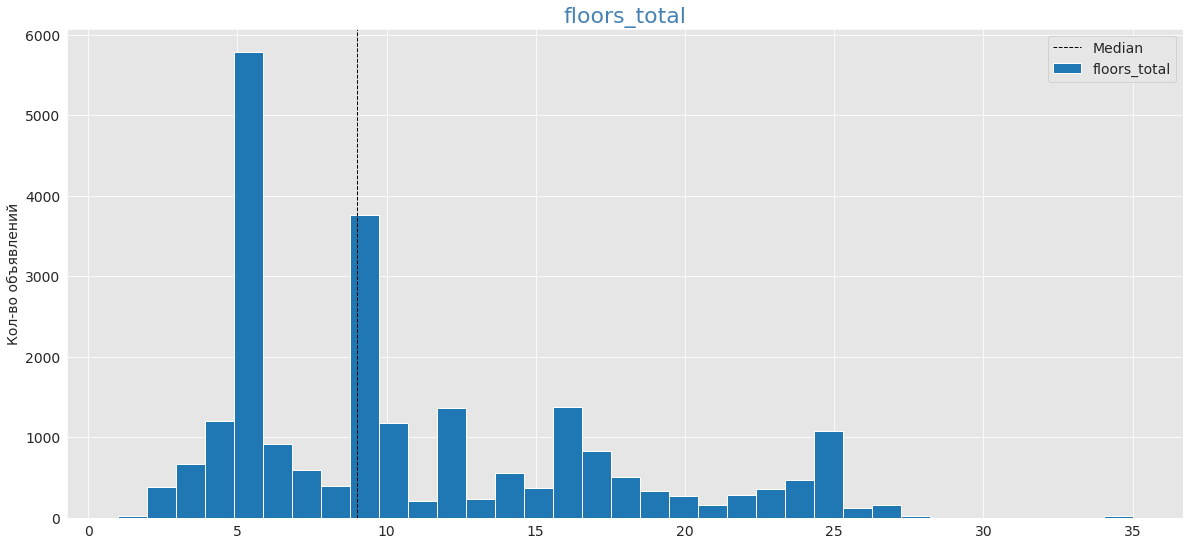

In [45]:
plot_histogram(df['floors_total'], plt_range=(1, 35), bins=35)

Видим пики на 5, 9, 12, 16 и 25 этажах
Возьмём эти значения за основу

In [46]:
def fill_total_floor(floor):
    '''
    принимаем значения floor
    возвращаем предполагаемую этажность в зависимости от значения floor
    За основу берём стандартную этажность, вычисленную ранее:
    5, 9, 12, 16 и 25
    для floor больше 25 возвращаем значение floor
    '''
    if floor <= 5:
        return 5
    elif floor <= 9:
        return 9
    elif floor <= 12:
        return 12
    elif floor <= 16:
        return 16
    elif floor <= 25:
        return 25
    else:
        return floor   


In [47]:
# заполним пропуски 
df['floors_total'].fillna(df['floor'].apply(fill_total_floor), inplace=True)

In [48]:
# Проверим корректность заполнения
df.query('floors_total < floor')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


##### Обработаем пропуски в locality_name

In [49]:
# посчитаем пропуски
count_na(df['locality_name'])

49

Как мы выяснили ранее в cityCenters_nearest указано расстояние до центра Санкт-Петербурга.

Ещё раз выведем минимальное расстояние до центра для каждого населенного пункта.

In [50]:
df.groupby('locality_name')['cityCenters_nearest'].min().sort_values().head(30)

locality_name
Санкт-Петербург              181.0
посёлок Шушары             17012.0
посёлок Парголово          17994.0
посёлок Стрельна           21813.0
поселок Мурино             21888.0
Пушкин                     24311.0
посёлок Левашово           25727.0
посёлок Песочный           25867.0
посёлок Лисий Нос          26368.0
посёлок Металлострой       26696.0
посёлок Петро-Славянка     27165.0
Красное Село               27317.0
посёлок Александровская    27352.0
посёлок Усть-Ижора         28212.0
поселок Лисий Нос          28246.0
Колпино                    29436.0
Петергоф                   29815.0
посёлок Понтонный          30709.0
Сестрорецк                 31130.0
Павловск                   31533.0
посёлок Щеглово            34085.0
посёлок Сапёрный           35822.0
Ломоносов                  36816.0
посёлок Белоостров         38868.0
посёлок Репино             42550.0
Кронштадт                  46657.0
Зеленогорск                51115.0
посёлок Молодёжное         64857.0
Боксит

У следующего за Санкт-Петербургом населённого пункта минимальное расстояние от центра чуть более 17 км.

Чтобы исключить ошибки, заполним пропуски в cityCenters_nearest для населенных пунктов с расстоянием до центра не более 17 км. значением "Санкт-Петербург".

В остальных случаях заменим пропуски заначениями "не указан"

In [51]:
df.loc[(df['locality_name'].isna()) 
       & (df['cityCenters_nearest'] <= 17000),
      'locality_name'] = 'Санкт-Петербург'
df['locality_name'].fillna('не указан', inplace=True)

In [52]:
# проверим сколько пропусков осталось
df.isna().sum().sort_values(ascending=False)

parks_nearest           15620
ponds_nearest           14589
ceiling_height           9195
cityCenters_nearest      5394
airports_nearest         5394
days_exposition          3181
kitchen_area             2114
living_area              1903
ponds_around3000            0
parks_around3000            0
locality_name               0
balcony                     0
total_images                0
last_price                  0
studio                      0
is_apartment                0
floor                       0
floors_total                0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

#### Рассмотрим типы данных в каждом столбце

In [53]:
# для начала посмотрим, какие у нас есть типы данных
df.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

first_day_exposition содержит дату, но имеет тип object. Чтобы дальше было проще работать с датой, преобразуем тип в datetime.
Выведем первые 20 значений и определимся с форматом

In [54]:
df['first_day_exposition'].head(20)

0     2019-03-07T00:00:00
1     2018-12-04T00:00:00
2     2015-08-20T00:00:00
3     2015-07-24T00:00:00
4     2018-06-19T00:00:00
5     2018-09-10T00:00:00
6     2017-11-02T00:00:00
7     2019-04-18T00:00:00
8     2018-05-23T00:00:00
9     2017-02-26T00:00:00
10    2017-11-16T00:00:00
11    2018-08-27T00:00:00
12    2016-06-30T00:00:00
13    2017-07-01T00:00:00
14    2016-06-23T00:00:00
15    2017-11-18T00:00:00
16    2017-11-23T00:00:00
17    2016-09-09T00:00:00
18    2017-01-27T00:00:00
19    2019-01-09T00:00:00
Name: first_day_exposition, dtype: object

Выглядит, что вермя всегда указано как 00:00, поэтому не будем его добавлять

In [55]:
#  преобразуем first_day_exposition в datetime
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')

##### Рассмотрим столбцы с типом float64

In [56]:
df.select_dtypes('float64').head(20)

,last_price,total_area,ceiling_height,floors_total,living_area,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,13000000.0,108.00,2.70,16.0,51.00,25.00,0.0,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,3350000.0,40.40,NaN,11.0,18.60,11.00,2.0,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,5196000.0,56.00,NaN,5.0,34.30,8.30,0.0,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,64900000.0,159.00,NaN,14.0,NaN,NaN,0.0,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,10000000.0,100.00,3.03,14.0,32.00,41.00,0.0,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,2890000.0,30.40,NaN,12.0,14.40,9.10,0.0,NaN,NaN,0.0,NaN,0.0,NaN,55.0
6,3700000.0,37.30,NaN,26.0,10.60,14.40,1.0,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,7915000.0,71.60,NaN,24.0,NaN,18.90,2.0,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,2900000.0,33.16,NaN,27.0,15.43,8.81,0.0,NaN,NaN,0.0,NaN,0.0,NaN,189.0
9,5400000.0,61.00,2.50,9.0,43.60,6.50,2.0,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Данные в столбцах floors_total, balcony, parks_around3000, ponds_around3000, days_exposition являются целыми числами. Например, у нас не может быть половина балкона. Их можно преобразовать в целочисленный тип.

Данные в столбцах last_price, airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest можно округлить, так как в них содержаться довольно большие значения. Для анализа нам будет достаточно точности в 1₽ или 1м

данные в столбцах total_area, ceiling_height, living_area и kitchen_area являются дробными, оставим как есть

In [57]:
# получим список с именами столбцов с типом float64
columns_to_convert =  df.dtypes[df.dtypes == 'float64'].index

# исключим из него total_area, ceiling_height, living_area и kitchen_area
columns_to_convert = columns_to_convert[~columns_to_convert.isin(['total_area', 'ceiling_height', 'living_area', 'kitchen_area'])]

In [58]:
# создадим словать для передачи в astype
columns_to_convert_dict = { col : 'int64' for col in columns_to_convert }

In [59]:
columns_to_convert_dict

{'last_price': 'int64',
 'floors_total': 'int64',
 'balcony': 'int64',
 'airports_nearest': 'int64',
 'cityCenters_nearest': 'int64',
 'parks_around3000': 'int64',
 'parks_nearest': 'int64',
 'ponds_around3000': 'int64',
 'ponds_nearest': 'int64',
 'days_exposition': 'int64'}

In [60]:
# выполним преобразование типов, ошибки будем инорировать
df = df.astype(columns_to_convert_dict, errors='ignore')

In [61]:
# проверим результат
df.dtypes

total_images                     int64
last_price                       int64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000                 int64
parks_nearest                  float64
ponds_around3000                 int64
ponds_nearest                  float64
days_exposition                float64
dtype: object

In [62]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,NaN,14,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


airports_nearest, cityCenters_nearest, arks_nearest и ponds_nearest не преобразовались из-за наличия пропусков.
Так как выше, решено было не заполнять пропуски, оставим тип без изменений

#### Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты

In [63]:
# для начала выведем число унакальных названий
df['locality_name'].nunique()

365

Для начала, заменим букву "ё" на "е"(в том числе заглавные)

In [64]:
df['locality_name'] = (df['locality_name'].str.replace('ё', 'е'))
df['locality_name'] = (df['locality_name'].str.replace('Ё', 'Е'))

In [65]:
# проверим, сколько осталось уникальных названий
df['locality_name'].nunique()

331

Проверим, какие типы у нас есть

In [66]:
def get_locality_type(name):
    '''
    принимает полное имя населённого пункта.
    Возвращает тип населённого пункта
    
    Пример get_locality_type("посёлок Алексеевка")
    Вернёт строку: "посёлок"
    '''
    # переведём строку в Series
    name_split = pd.Series(list(name))
    
    # найдём индекс первой заглавной буквы
    try:
        idx_of_upper = name_split[name_split.str.istitle() == True].index[0]
    # в случае ошибки вернём имя полностью
    except:
        return name
    
    return name[: idx_of_upper - 1]

In [67]:
%%time
locality_types = df['locality_name'].apply(get_locality_type)

CPU times: user 12.1 s, sys: 28.2 ms, total: 12.2 s
Wall time: 12.2 s


In [68]:
locality_types.unique()

array(['Санкт-Петербур', 'поселок', 'городской поселок', 'Ломоносо',
       'Сертолов', 'Петерго', 'Пушки', 'деревня', 'Коммуна', 'Колпин',
       'поселок городского типа', 'Гатчин', 'Выбор', 'Кронштад', 'Кировс',
       'садовое товарищество', 'Павловс', 'Всеволожс', 'Волхо',
       'Кингисеп', 'Приозерс', 'Сестрорец', 'Красное Сел', 'Сясьстро',
       'Сланц', 'село', 'Ивангоро', 'Мурин', 'Шлиссельбур', 'Никольско',
       'Зеленогорс', 'Сосновый Бо', 'Кудров', 'Кириш', 'Луг', 'Волосов',
       'Отрадно', 'Тихви', 'Тосн', 'Бокситогорс', 'Пикалев', 'Подпорожь',
       'Приморс', 'Новая Ладог', 'поселок городского типа имени',
       'поселок станции', 'не указан', 'Лодейное Пол', 'Светогорс',
       'Любан', 'Каменногорс',
       'садоводческое некоммерческое товарищество',
       'поселок при железнодорожной станции', 'коттеджный поселок',
       'Высоц'], dtype=object)

Заменим именя населённых пунктов следующим образом
- "городской поселок" на "поселок городского типа"
- "садоводческое некоммерческое товарищество" на "садоводческое товарищество"
- "коттеджный поселок" на "поселок"
- "поселок при железнодорожной станции" на "поселок станции"

In [69]:
# создадим словарь для замены
names_to_replace_dict = {
    'городской поселок': 'поселок городского типа',
    'садоводческое некоммерческое товарищество': 'садоводческое товарищество',
    'коттеджный поселок': 'поселок',
    "поселок при железнодорожной станции": "поселок станции",
}

In [70]:
#создадим столбец с новыми названиями
df['new_loacality_name'] = df['locality_name']

In [71]:
# заменим в созданном столбце названия с помощью словаря
for key, value in names_to_replace_dict.items():
    df['new_loacality_name'] = df['new_loacality_name'].str.replace(key, value)

In [72]:
 df['new_loacality_name'].nunique()

321

#### Найдём и устраним редкие и выбивающиеся значения

Выведем описание, чтобы понять на какие столбцы обратить внимание

In [73]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23699.0,1.067923e+01,6.599753e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21585.0,1.048950e+01,5.954128e+00,0.0,7.00,9.00,12.0,112.0
balcony,23699.0,5.910798e-01,9.592982e-01,0.0,0.00,0.00,1.0,5.0


##### Устраним выбивающиеся значения в столбце last_price

В первую очередь смущает цена в 12190₽.
Проверим, объекты с ценой до 500 000₽

In [74]:
df[df['last_price'] < 500000] 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name
5698,7,450000,42.0,2017-07-31,2,NaN,1,23.0,1,False,...,0,городской поселок Будогощь,NaN,NaN,0,NaN,0,NaN,233.0,поселок городского типа Будогощь
6859,6,490000,40.0,2017-12-11,1,NaN,5,NaN,3,False,...,0,деревня Старополье,NaN,NaN,0,NaN,0,NaN,43.0,деревня Старополье
8793,7,12190,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8.0,Санкт-Петербург
9581,7,450000,43.4,2018-08-31,2,NaN,5,30.3,3,False,...,0,деревня Старополье,NaN,NaN,0,NaN,0,NaN,96.0,деревня Старополье
10782,3,490000,29.1,2016-05-05,1,2.50,5,17.0,5,False,...,0,Сланцы,NaN,NaN,0,NaN,0,NaN,719.0,Сланцы
14911,5,430000,54.0,2018-06-26,2,NaN,3,NaN,3,False,...,0,поселок станции Свирь,NaN,NaN,0,NaN,0,NaN,44.0,поселок станции Свирь
16032,8,480000,32.0,2019-01-06,1,NaN,2,16.0,1,False,...,0,Сланцы,NaN,NaN,0,NaN,0,NaN,83.0,Сланцы
16219,14,450000,38.5,2018-07-11,2,2.65,2,NaN,1,False,...,0,деревня Вахнова Кара,NaN,NaN,0,NaN,0,NaN,45.0,деревня Вахнова Кара
16274,18,440000,40.0,2018-07-10,1,NaN,5,NaN,1,False,...,0,деревня Старополье,NaN,NaN,0,NaN,0,NaN,45.0,деревня Старополье
17456,7,430000,30.4,2019-04-22,1,NaN,2,16.0,1,False,...,0,Сланцы,NaN,NaN,0,NaN,0,NaN,NaN,Сланцы


Из вызывающих подозрение видим, только один объект. Оценим объекты с похожей площадью, чтобы поянть как можно исправить ошибку

In [75]:
df.query('total_area > 100 and total_area <110')['last_price'].median()

11999500.0

Добавим к значению 3 нуля тогда цена станет адекватной

In [76]:
# умножим значение на 1000
df.loc[df['last_price'] < 20000, 'last_price'] = df.loc[df['last_price'] < 20000, 'last_price'] * 1000

Посмотрим на распределение цены

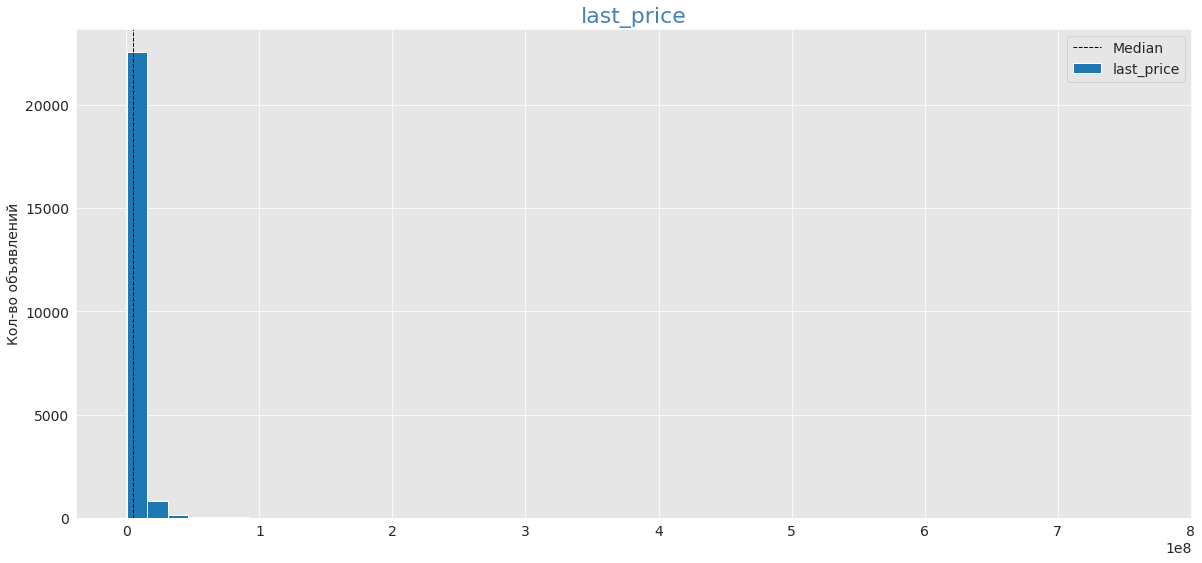

In [77]:
plot_histogram(df['last_price'])

In [78]:
# рассмотрим объекты ценой более 30 000 000
df.query('last_price > 10000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург
3,0,64900000,159.00,2015-07-24,3,NaN,14,NaN,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,Санкт-Петербург
19,16,14200000,121.00,2019-01-09,3,2.75,16,76.0,8,False,...,0,Санкт-Петербург,38900.0,12843.0,0,NaN,0,NaN,97.0,Санкт-Петербург
35,6,15500000,149.00,2017-06-26,5,NaN,5,104.0,4,False,...,0,Санкт-Петербург,23670.0,3502.0,0,NaN,1,779.0,644.0,Санкт-Петербург
42,13,22000000,161.80,2015-07-08,4,2.80,4,80.9,2,False,...,5,Петергоф,35416.0,30605.0,2,47.0,1,907.0,987.0,Петергоф
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23631,17,14799000,104.00,2018-11-18,3,3.10,4,66.0,2,False,...,1,Санкт-Петербург,39047.0,13944.0,0,NaN,1,553.0,90.0,Санкт-Петербург
23648,14,10100000,78.00,2017-05-12,3,3.27,5,48.6,5,False,...,0,Санкт-Петербург,20933.0,1113.0,1,621.0,2,117.0,621.0,Санкт-Петербург
23653,10,11000000,74.00,2018-11-04,2,2.50,18,40.0,10,False,...,0,Санкт-Петербург,35916.0,12830.0,0,NaN,0,NaN,NaN,Санкт-Петербург
23684,20,21400000,145.00,2018-11-02,4,3.00,26,71.4,17,False,...,0,Санкт-Петербург,11827.0,11459.0,0,NaN,0,NaN,NaN,Санкт-Петербург


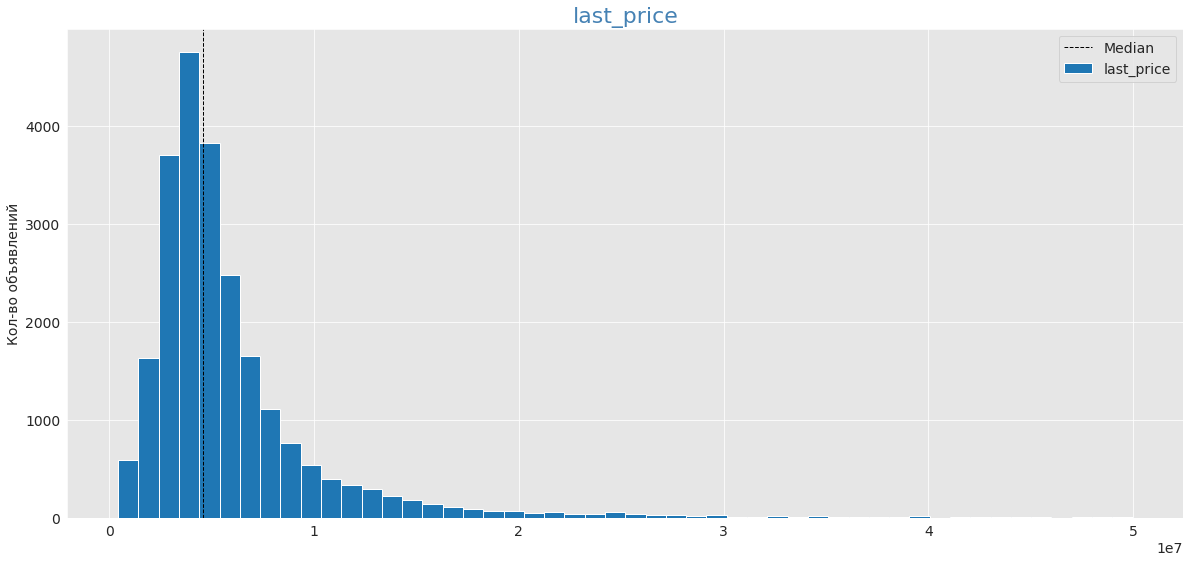

In [79]:
plot_histogram(df.query('last_price < 50000000')['last_price'])

Исключим слишком дорогую недвижимость с ценой от 30 млн. ₽

In [80]:
df = df.drop(df.query('last_price >= 30000000').index)

##### Устраним выбивающиеся значения в столбце total_area

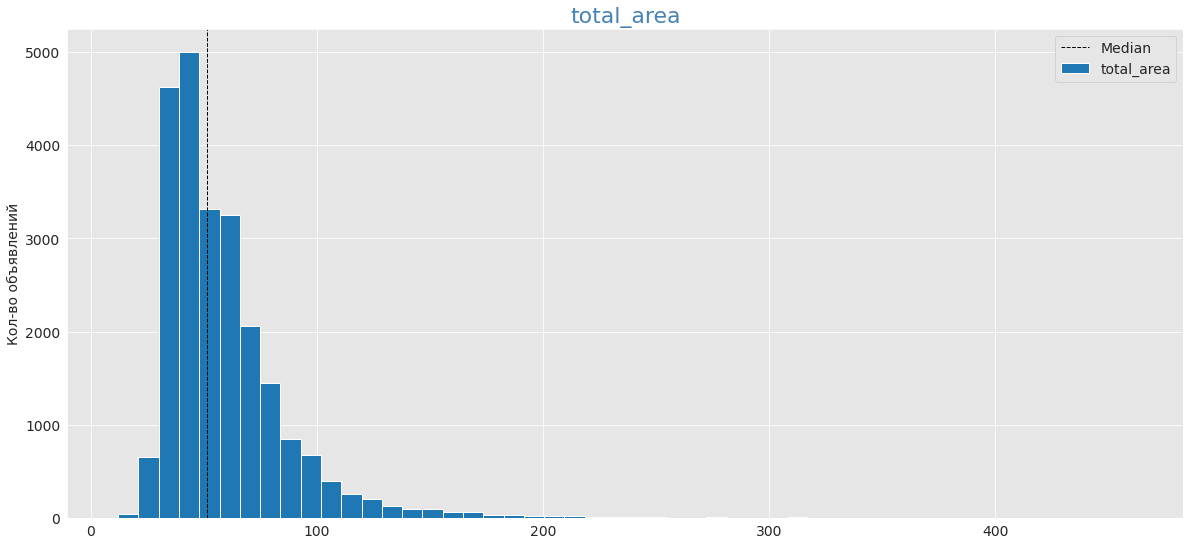

In [81]:
plot_histogram(df['total_area'])

Видим, что у нас довольно мало объектов с площадью более 200 кв. м.
Рассмотрим их

In [82]:
df[df['total_area'] >= 200]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name
521,20,25717300,230.1,2015-01-21,3,NaN,3,130.0,1,False,...,1,Пушкин,16877.0,29030.0,2,676.0,3,278.0,1441.0,Пушкин
679,13,13700000,200.0,2017-09-27,4,2.90,4,90.0,1,False,...,0,Петергоф,38993.0,34182.0,1,233.0,1,234.0,172.0,Петергоф
681,20,24900000,249.0,2015-08-13,7,NaN,5,180.0,4,False,...,1,Санкт-Петербург,24810.0,6108.0,0,NaN,0,NaN,781.0,Санкт-Петербург
813,7,16500000,229.0,2016-02-25,8,NaN,6,160.0,5,False,...,0,Санкт-Петербург,23968.0,4536.0,1,243.0,0,NaN,806.0,Санкт-Петербург
866,5,25000000,363.0,2017-12-23,14,3.16,5,222.0,4,False,...,0,Санкт-Петербург,38076.0,7950.0,0,NaN,2,435.0,418.0,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22238,12,19500000,287.5,2017-12-27,7,NaN,4,183.7,3,False,...,0,Санкт-Петербург,21881.0,4726.0,1,578.0,1,853.0,90.0,Санкт-Петербург
22649,18,22900000,206.0,2016-04-04,7,NaN,6,142.0,2,False,...,0,Санкт-Петербург,25079.0,5544.0,0,NaN,1,251.0,75.0,Санкт-Петербург
22835,20,29000000,275.0,2018-07-27,5,NaN,17,180.0,17,False,...,0,Санкт-Петербург,37593.0,13114.0,1,570.0,3,502.0,91.0,Санкт-Петербург
23281,20,24800000,231.2,2015-01-21,6,3.10,5,99.8,4,False,...,0,Санкт-Петербург,21480.0,2453.0,3,75.0,1,795.0,NaN,Санкт-Петербург


Удалим их из датасета

In [83]:
df = df.drop(df.query('total_area > 200').index)

##### Устраним выбивающиеся значения в столбце living_area

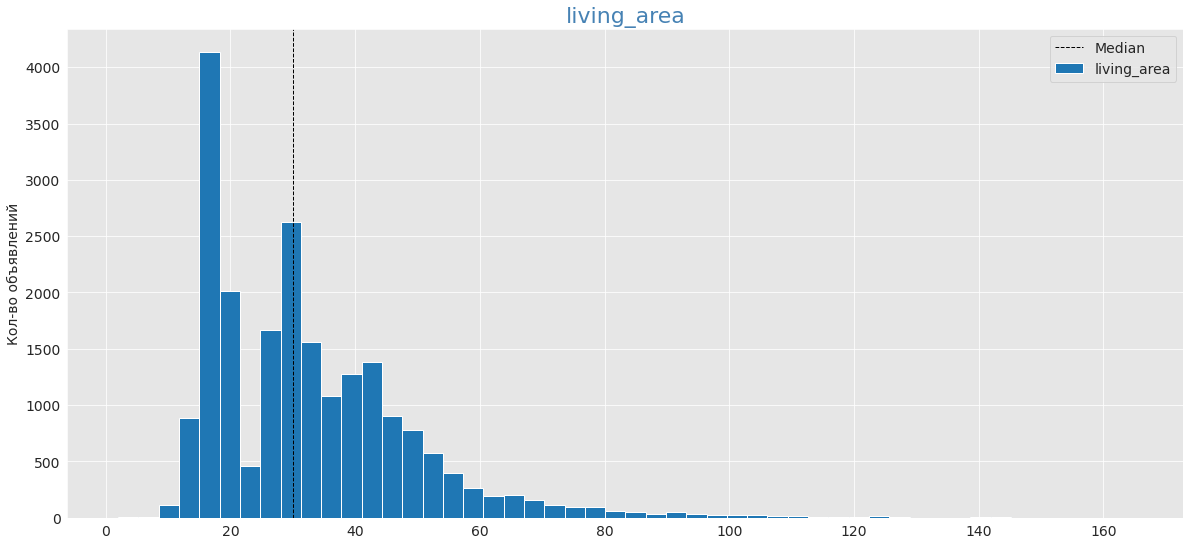

In [84]:
plot_histogram(df['living_area'])

Рассмотрим объекты с жилой площадью менее 10 кв. м.

In [85]:
df.query('living_area < 10')[['total_area', 'living_area', 'kitchen_area', 'is_apartment', 'studio', 'open_plan']]

,total_area,living_area,kitchen_area,is_apartment,studio,open_plan
114,21.40,8.3,6.3,False,False,False
680,43.00,9.0,23.0,False,False,False
1326,52.00,9.0,32.0,False,False,False
2309,62.40,8.4,41.0,False,False,False
3242,41.00,3.0,11.0,False,False,False
4100,34.80,9.0,17.1,False,False,False
4542,18.00,9.0,NaN,False,False,False
7312,27.00,9.0,16.0,False,False,False
8325,52.00,9.0,6.0,False,False,False
13915,52.00,2.0,9.0,False,False,False


Сомнительно, что площадь кухни может быть больше жилой площади, найдём все такие строки

In [86]:
(df.query('living_area < kitchen_area')[['total_area', 'living_area', 'kitchen_area', 'is_apartment', 'studio', 'open_plan']]
.sort_values('kitchen_area', ascending=False))

,total_area,living_area,kitchen_area,is_apartment,studio,open_plan
15780,119.6,36.4,64.0,False,False,False
19499,118.0,36.0,64.0,False,False,False
14900,125.6,42.7,62.5,False,False,False
3561,115.0,45.0,60.0,False,False,False
4320,146.3,55.8,56.2,False,False,False
...,...,...,...,...,...,...
17111,32.0,11.5,11.8,False,False,False
3242,41.0,3.0,11.0,False,False,False
21368,33.0,10.0,11.0,False,False,False
21943,77.6,5.4,9.8,False,False,False


В найденных строках поменяем значения living_area иkitchen_area местами

In [87]:
# выберем строки, которые мы хотим заменить
columns_to_change = df.query('living_area < kitchen_area')[['kitchen_area', 'living_area']]

# поменяем в них названия строк местами
columns_to_change.columns = ['living_area', 'kitchen_area']

In [88]:
# заменим строки в которых площадь кухни больше жилой
df.loc[df['living_area'] < df['kitchen_area'], ['living_area', 'kitchen_area']] = columns_to_change

In [89]:
# Проверим корректность замены
df.query('living_area < kitchen_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name


Удалим оставшиеся объекты в которых жилая площадь меньше 10 кв. м.

In [90]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23281.000000,2.328100e+04,23281.000000,23281.000000,14232.000000,23281.000000,21424.000000,23281.000000,21210.000000,23281.000000,17889.000000,17889.000000,23281.000000,7785.000000,23281.000000,8802.000000,20202.000000
mean,9.815515,5.671933e+06,57.475724,2.023238,2.761055,10.736824,32.996511,5.906576,10.083419,0.592672,28914.330874,14415.193499,0.453589,494.051638,0.574546,522.166439,178.965548
std,5.653439,3.884128e+06,25.309111,0.986386,1.268888,6.623855,16.771243,4.905620,4.790736,0.958331,12777.537979,8604.107631,0.731651,342.976678,0.869315,277.696820,217.480504
min,0.000000,4.300000e+05,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.500000,5.000000,18.600000,2.000000,7.000000,0.000000,18500.000000,9632.000000,0.000000,290.000000,0.000000,302.000000,45.000000
50%,9.000000,4.600000e+06,51.300000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26786.000000,13222.000000,0.000000,456.000000,0.000000,506.000000,95.000000
75%,14.000000,6.600000e+06,68.000000,3.000000,2.800000,16.000000,42.000000,8.000000,11.600000,1.000000,37419.000000,16446.000000,1.000000,614.000000,1.000000,733.000000,229.000000
max,50.000000,2.999900e+07,200.000000,11.000000,100.000000,60.000000,164.700000,33.000000,65.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [91]:
df = df.drop(df.query('living_area < 10').index)

##### Устраним выбивающиеся значения в столбце  kitchen_area

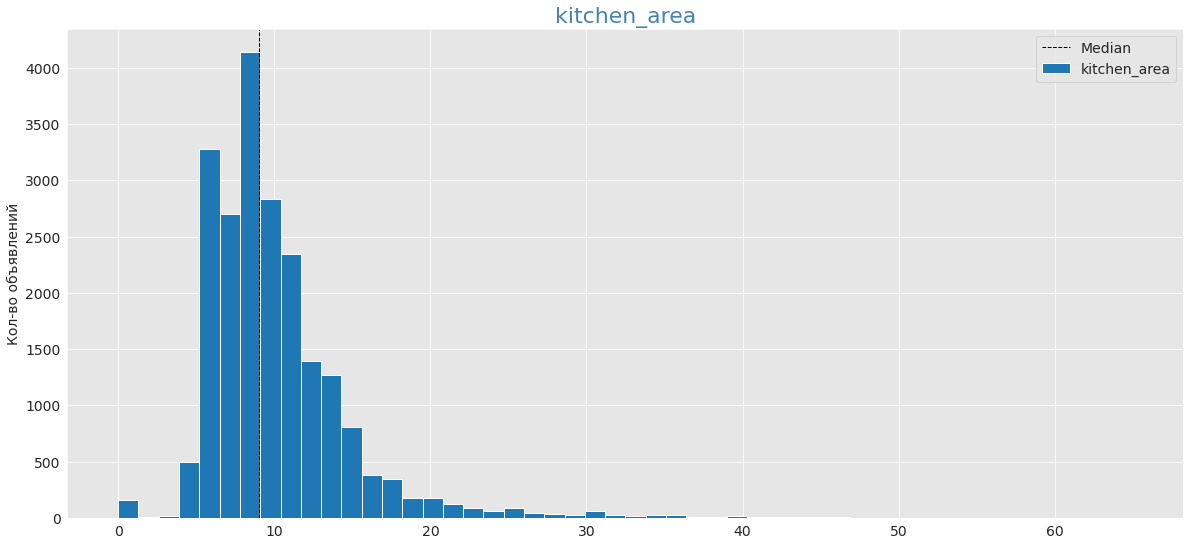

In [92]:
# рассмотрим распределение
plot_histogram(df['kitchen_area'])

Так как квартир с площадью кухни больше 50 кв. м. мало, удалим их из датасета

In [93]:
df = df.drop(df.query('kitchen_area > 50').index)

##### Устраним выбивающиеся значения в столбце ceiling_height

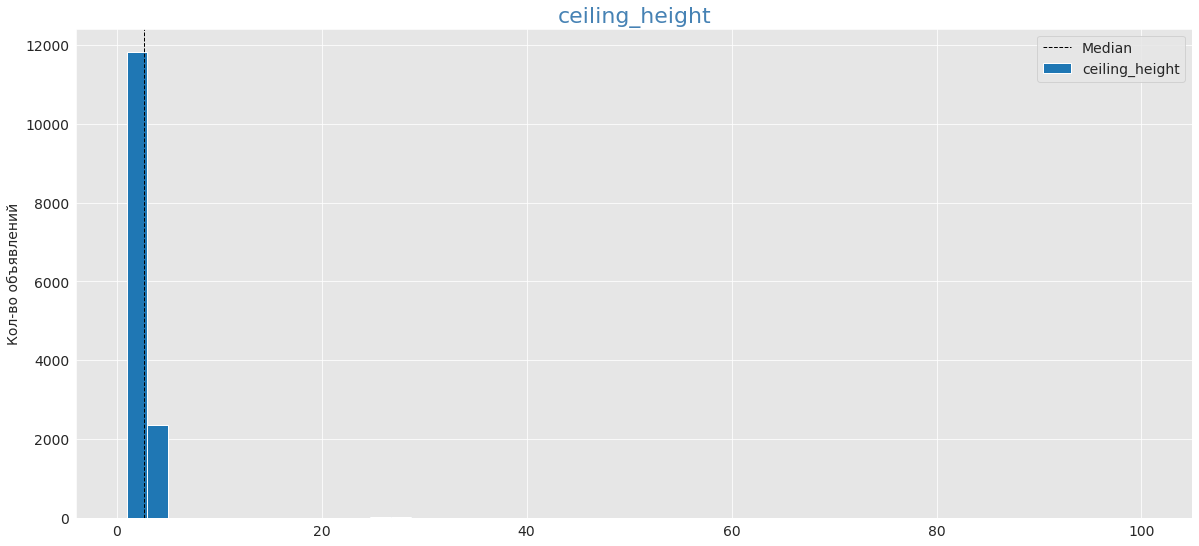

In [94]:
#построим распределение 
plot_histogram(df['ceiling_height'])

Высота потолков менее 2-х и более 10-ти метров выглядит подозрительно. Ознакомимся с такими объектами

In [95]:
df.query('ceiling_height < 2 or ceiling_height > 10').sort_values('ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name
22590,16,6000000,55.0,2018-10-31,2,1.00,12,32.4,7,False,...,0,Санкт-Петербург,33053.0,14217.0,2,293.0,2,289.0,13.0,Санкт-Петербург
5712,5,1500000,42.8,2017-08-14,2,1.20,2,27.5,1,False,...,0,городской поселок Мга,NaN,NaN,0,NaN,0,NaN,248.0,поселок городского типа Мга
16934,5,4100000,40.0,2017-10-17,1,1.75,37,17.4,5,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,71.0,Санкт-Петербург
22309,20,5300000,45.0,2017-09-30,1,10.30,16,15.5,15,False,...,0,Санкт-Петербург,36353.0,11936.0,2,440.0,2,450.0,136.0,Санкт-Петербург
15061,19,5600000,56.4,2018-05-11,2,14.00,14,32.4,5,False,...,2,Санкт-Петербург,14814.0,13610.0,0,NaN,0,NaN,315.0,Санкт-Петербург
17496,15,6700000,92.9,2019-02-19,3,20.00,17,53.2,14,False,...,5,Санкт-Петербург,16295.0,15092.0,1,967.0,0,NaN,NaN,Санкт-Петербург
20507,12,5950000,60.0,2018-02-19,2,22.60,14,35.0,11,False,...,1,Санкт-Петербург,27028.0,12570.0,0,NaN,0,NaN,40.0,Санкт-Петербург
5076,0,3850000,30.5,2018-10-03,1,24.00,5,19.5,1,True,...,0,Санкт-Петербург,29686.0,8389.0,3,397.0,1,578.0,7.0,Санкт-Петербург
355,17,3600000,55.2,2018-07-12,2,25.00,5,32.0,2,False,...,2,Гатчина,NaN,NaN,0,NaN,0,NaN,259.0,Гатчина
18545,6,3750000,43.0,2019-03-18,2,25.00,5,29.0,3,False,...,0,Санкт-Петербург,27054.0,8033.0,1,540.0,0,NaN,12.0,Санкт-Петербург


In [96]:
# присвоим для потолков выше 10 метров разделим занчение высоты на 10
df.loc[df['ceiling_height'] > 10, ['ceiling_height']] = df.loc[df['ceiling_height'] > 10, ['ceiling_height']] / 10

В датасете оставим значения с потолками от 2-х до 4-х метров

In [97]:
df.shape

(23266, 23)

In [98]:
df = df.drop(df.query('ceiling_height < 2 or ceiling_height >= 4').index)

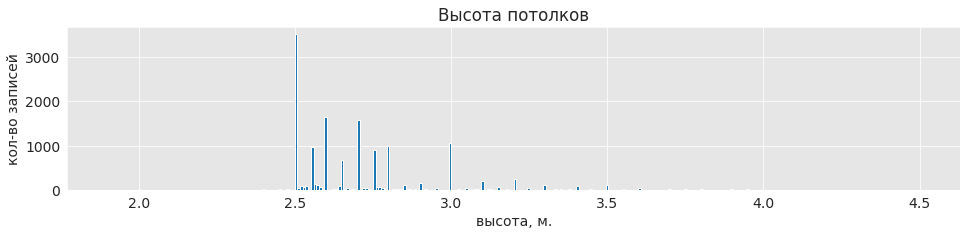

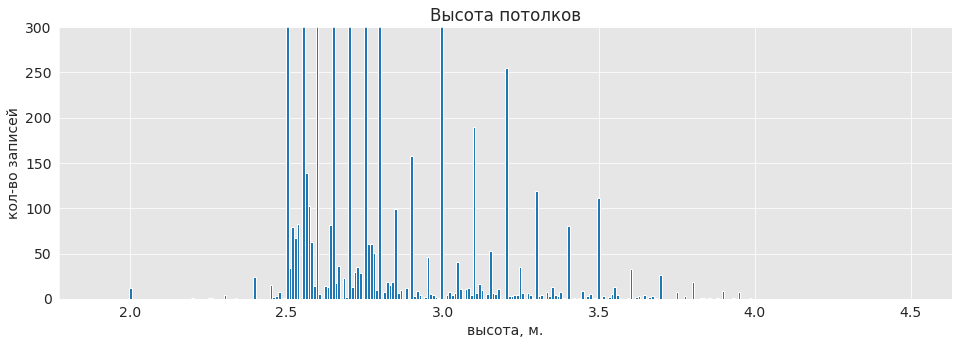

In [99]:
# построим график значений для столбца с высотой потолков

import matplotlib.pyplot as plt

(
    df['ceiling_height']
        .sort_values()
        .plot(y='ceiling_height', kind='hist', 
              bins=300, range=(1.9,4.5), grid=True, title='Высота потолков', figsize=(16,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'высота, м.')
)
plt.show()
(
    df['ceiling_height']
        .sort_values()
        .plot(y='ceiling_height', kind='hist', 
              bins=300, range=(1.9,4.5), grid=True, title='Высота потолков', figsize=(16,5))
        .set(ylim = (0, 300), ylabel = 'кол-во записей', xlabel = 'высота, м.')
        
)
plt.show()

##### Устраним выбивающиеся значения в столбце rooms

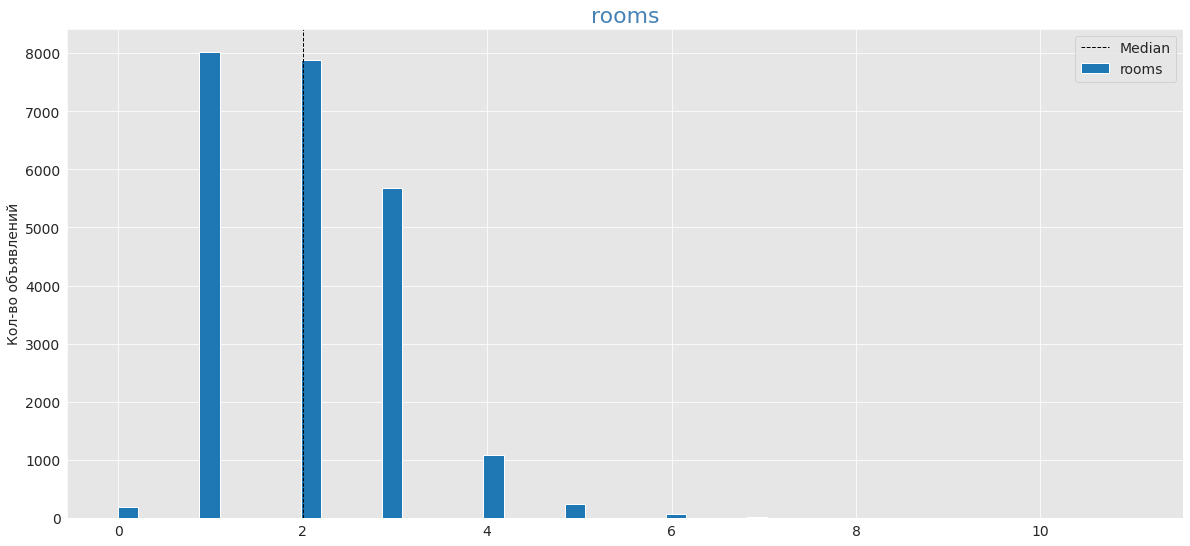

In [100]:
# рассмотрим распределение
plot_histogram(df['rooms'])

Посмотрим на объекты с более чем 7-ю комнатами

In [101]:
df.query('rooms > 7')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name
648,3,17500000,183.7,2018-07-01,11,3.40,7,138.8,7,False,...,0,Санкт-Петербург,23606.0,3148.0,0,NaN,0,NaN,NaN,Санкт-Петербург
4435,13,22190000,191.2,2017-12-05,8,2.90,6,115.8,1,False,...,0,Санкт-Петербург,21589.0,1152.0,1,587.0,2,155.0,115.0,Санкт-Петербург
8758,5,16100000,150.0,2018-07-10,8,2.92,5,107.0,1,False,...,0,Санкт-Петербург,26080.0,4782.0,2,473.0,0,NaN,NaN,Санкт-Петербург


Проверим, объекты с нулём комнат. возможно это квартиры со свободной планировкой, апартаменты или студии

In [102]:
df.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name
144,1,2450000,27.00,2017-03-30,0,NaN,24,15.50,2,False,...,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,181.0,поселок Мурино
349,4,2320000,25.00,2017-09-27,0,NaN,14,17.00,1,False,...,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,45.0,деревня Кудрово
440,8,2480000,27.11,2018-03-12,0,NaN,17,24.75,4,False,...,2,Санкт-Петербург,38171.0,15015.0,0,NaN,2,982.0,64.0,Санкт-Петербург
508,0,3375000,34.40,2017-03-28,0,NaN,26,24.30,19,False,...,1,поселок Парголово,53115.0,19292.0,0,NaN,1,593.0,430.0,поселок Парголово
608,2,1850000,25.00,2019-02-20,0,NaN,10,NaN,7,False,...,0,поселок Шушары,17427.0,24212.0,0,NaN,0,NaN,29.0,поселок Шушары
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000,26.00,2017-09-01,0,NaN,25,18.00,16,False,...,0,Санкт-Петербург,11405.0,13222.0,0,NaN,1,623.0,14.0,Санкт-Петербург
23442,0,2500000,27.70,2017-09-28,0,NaN,24,18.00,4,False,...,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,4.0,поселок Мурино
23554,15,3350000,26.00,2018-09-07,0,NaN,19,NaN,8,False,...,0,Санкт-Петербург,18090.0,17092.0,0,NaN,2,112.0,31.0,Санкт-Петербург
23592,10,1450000,29.00,2017-11-11,0,NaN,9,18.00,8,False,...,2,Никольское,NaN,NaN,0,NaN,0,NaN,82.0,Никольское


In [103]:
#посчитаем, сколько у нас есть объектов с нулём комнат каждого типа
df.query('rooms == 0')[['studio', 'is_apartment', 'open_plan']].sum()

studio          135
is_apartment      0
open_plan        58
dtype: int64

Так как в студии есть 1 общая комната, заменим в таких объектах 0 в 1
Количество комнат в квартирах со свободной планировкой трогать не будем

In [104]:
df.loc[(df['rooms'] == 0) & (df['studio']), 'rooms'] = 1

Так как квартир с более чем 7-ю комнатами немного, удалим эти объекты из датасета

In [105]:
df = df.drop(df.query('rooms > 7').index)

##### Устраним выбивающиеся значения в столбце floors_total

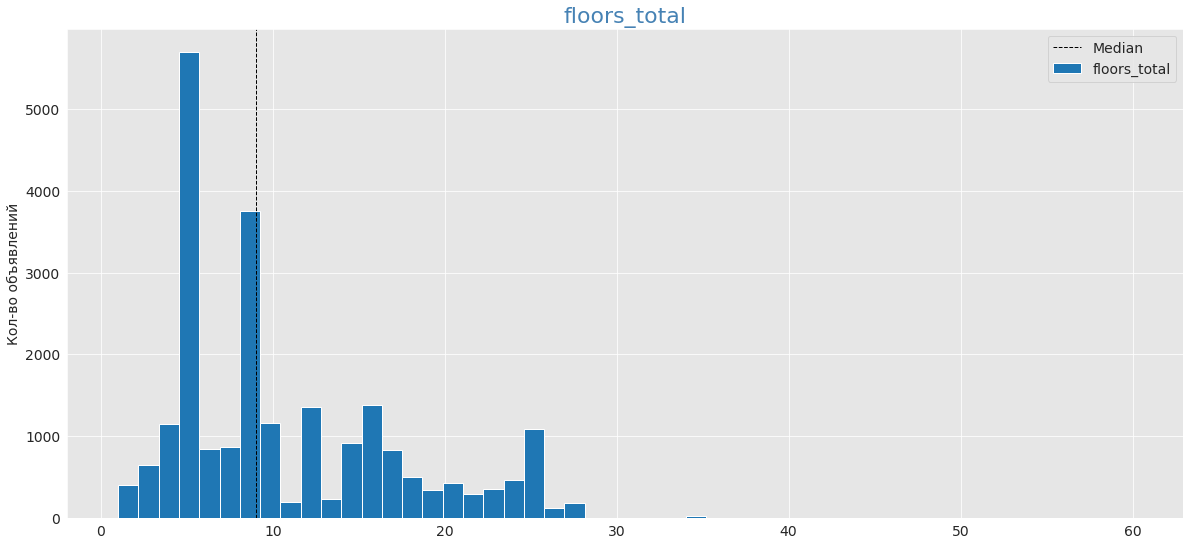

In [106]:
plot_histogram(df['floors_total'])

Расмотрим объекты с более чем 30-ю этажами

In [107]:
df.query('floors_total >30').sort_values('floors_total')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name
11575,9,9900000,101.0,2016-04-28,3,NaN,33,53.0,32,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,53.0,Санкт-Петербург
1697,11,3550000,28.0,2018-02-08,1,2.65,34,18.0,23,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,410.0,Санкт-Петербург
9579,9,3450000,24.8,2019-02-01,1,2.68,35,16.0,17,False,...,2,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,45.0,Санкт-Петербург
21599,12,6200000,51.0,2017-08-27,2,NaN,35,27.0,13,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,NaN,Санкт-Петербург
20938,18,9900000,100.9,2019-04-08,3,NaN,35,53.4,22,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,NaN,Санкт-Петербург
18629,20,5700000,54.0,2017-12-08,1,NaN,35,21.0,31,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,128.0,Санкт-Петербург
18617,8,7350000,68.5,2017-10-09,2,NaN,35,27.0,3,False,...,1,Санкт-Петербург,18627.0,20339.0,1,609.0,3,145.0,41.0,Санкт-Петербург
18218,4,9900000,101.0,2018-09-27,3,NaN,35,53.4,33,False,...,2,Санкт-Петербург,18737.0,20450.0,0,NaN,3,72.0,7.0,Санкт-Петербург
15982,1,5900000,62.0,2015-03-01,2,NaN,35,34.0,9,False,...,1,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,547.0,Санкт-Петербург
14347,14,8595000,69.7,2018-09-26,2,NaN,35,27.4,26,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,NaN,Санкт-Петербург


Здания с высотой более 36 этажей выглядят подозрительно. Удалим такие строки

In [108]:
df = df.drop(df.query('floors_total > 36').index)

##### Устраним выбивающиеся значения в столбце floor

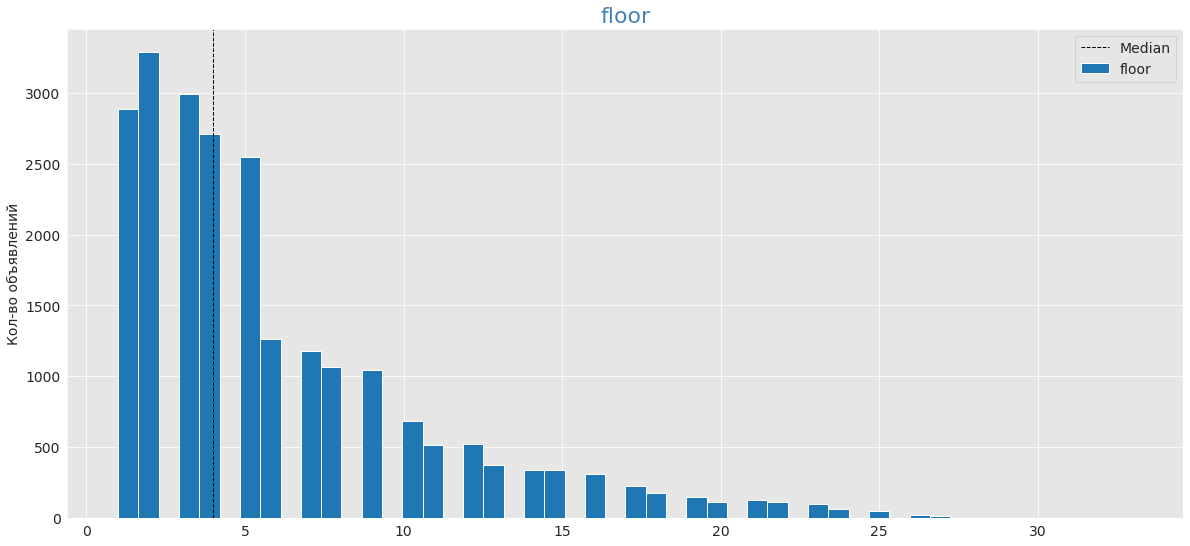

In [109]:
plot_histogram(df['floor'])

в столбце floor данные выглядят нормально, не будем их трогать

##### Устраним выбивающиеся значения в столбце airports_nearest

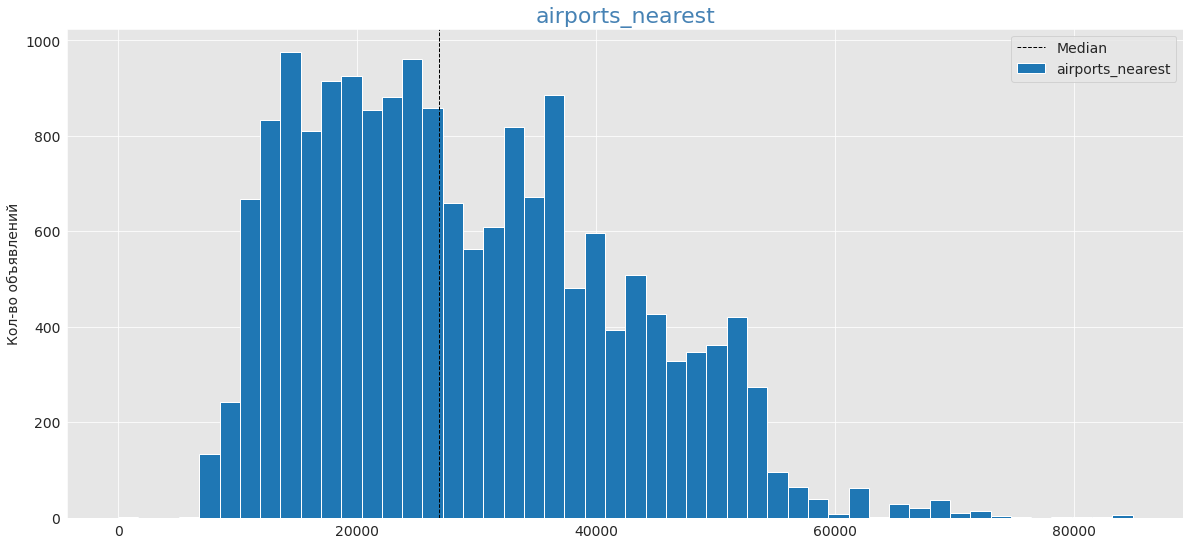

In [110]:
plot_histogram(df['airports_nearest'])

У нас есть объекты с расстоянием до аэропорта равным нулю. Проверим, что же это за оббъекты

In [111]:
# выведем  объекты с расстоянием до аэропорта меншьше 1км.
df.query('airports_nearest < 1000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name
21085,0,7000000,34.7,2018-09-23,1,2.7,9,19.8,3,False,...,2,Санкт-Петербург,0.0,22801.0,0,NaN,0,NaN,60.0,Санкт-Петербург


Восстановить значение не получится, удалим этот объект

In [112]:
df = df.query('airports_nearest != 0')

##### Устраним выбивающиеся значения в столбце days_exposition

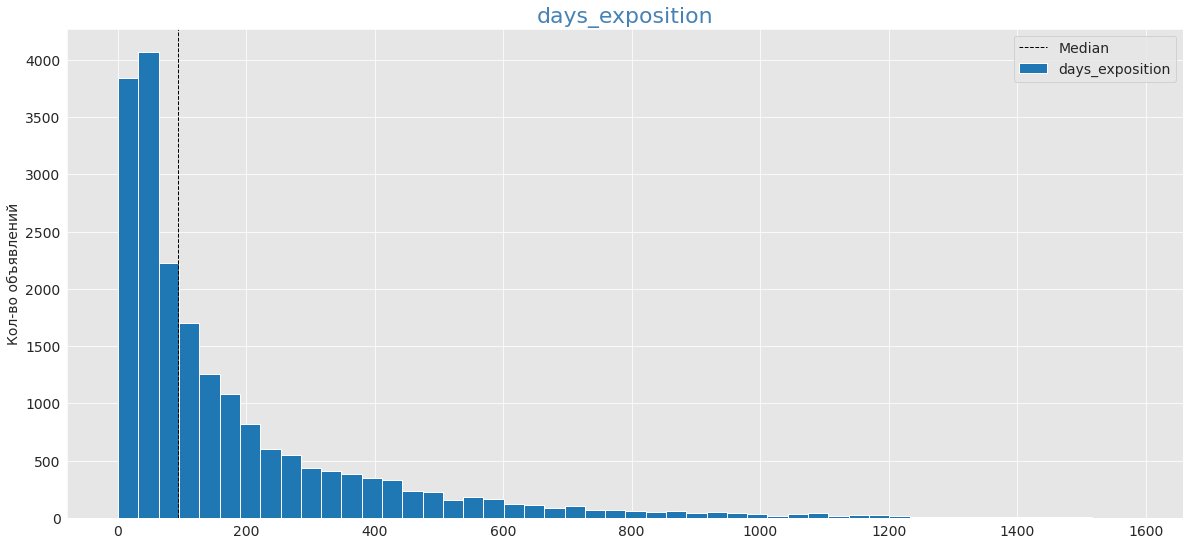

In [113]:
# построим гистограмму
plot_histogram(df['days_exposition'])

Значения более 800 явно выбросы, удалим такие строки

In [114]:
df = df.drop(df.query('days_exposition > 800').index)

Проверим описание ещё раз

In [115]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,22627.0,9.839042e+00,5.648354e+00,0.0,6.0,9.00,14.0,50.00
last_price,22627.0,5.617053e+06,3.823428e+06,430000.0,3400000.0,4550000.00,6500000.0,29999000.00
total_area,22627.0,5.711106e+01,2.495548e+01,12.0,40.0,51.00,67.7,200.00
rooms,22627.0,2.020153e+00,9.701824e-01,0.0,1.0,2.00,3.0,7.00
ceiling_height,13776.0,2.706289e+00,2.382895e-01,2.0,2.5,2.65,2.8,3.98
floors_total,22627.0,1.075609e+01,6.613868e+00,1.0,5.0,9.00,16.0,36.00
living_area,20812.0,3.278469e+01,1.656098e+01,10.0,18.6,30.00,41.7,164.70
floor,22627.0,5.919919e+00,4.908168e+00,1.0,2.0,4.00,8.0,33.00
kitchen_area,20595.0,1.002326e+01,4.651015e+00,0.0,7.0,9.00,11.5,50.00
balcony,22627.0,5.957926e-01,9.608053e-01,0.0,0.0,0.00,1.0,5.00


In [116]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных показателях 
# в выбранных параметрах о продаже квартир

(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,627.00","22,627.00","13,776.00","19,570.00","22,627.00","20,812.00","20,595.00","22,627.00","22,627.00"
min,0.00,12.00,2.00,1.00,"430,000.00",10.00,0.00,1.00,1.00
max,7.00,200.00,3.98,800.00,"29,999,000.00",164.70,50.00,33.00,36.00


### Посчитайте и добавьте в таблицу новые столбцы

Добавим центу одного квадратного метра

In [117]:
# разделим  цену на площадь, преобразуем в целочисленный тип и присвоим новой колонке
df['one_sqr_meter_price'] = (df['last_price'] / df['total_area']).astype('int')

Добавим день, месяц и год публикации объявления

In [118]:
df['day_of_week'] = df['first_day_exposition'].dt.dayofweek
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

In [119]:
df['day_of_week']

0        3
1        1
2        3
4        1
5        0
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: day_of_week, Length: 22627, dtype: int64

Добавим тип этажа

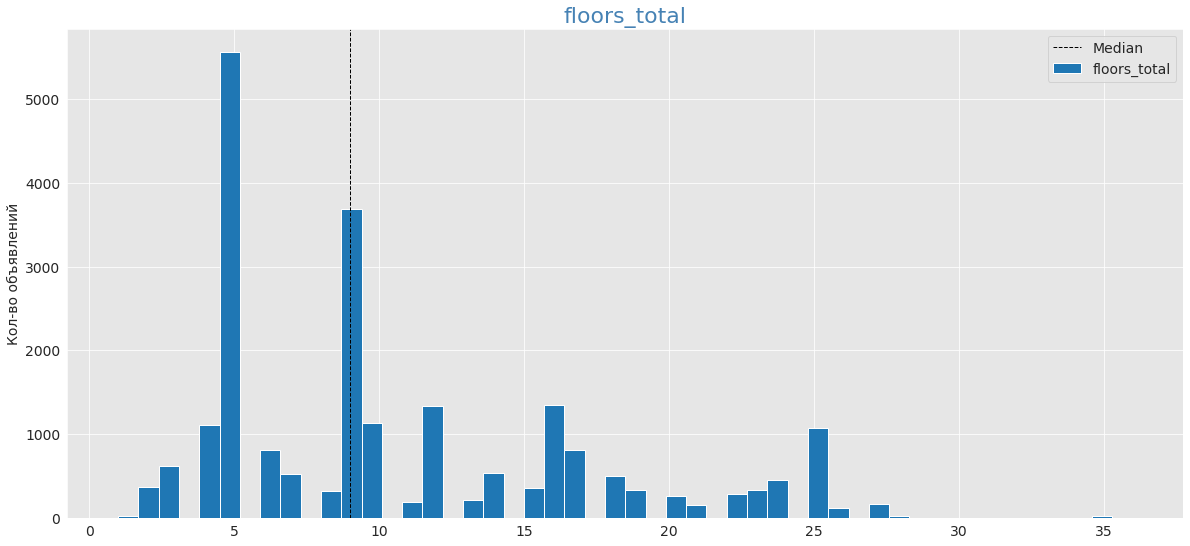

In [119]:
plot_histogram(df.floors_total)

In [120]:
values = [-1, -2]

In [121]:
%%time
values = list(map(abs, values))

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11 µs


In [122]:
%%time
values[0] = abs(values[0])
values[1] = abs(values[1])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


In [123]:
def get_floor_type(row):
    '''
    Функция принимает список с значением этажа и количество этажей в доме.
    выдаёт тип этажа «первый», «последний», «другой»
    в случае ошибки отдаёт значение «другой»
    '''
    try: 
        # отрицательного количества этажей быть точно не может
        # отрицательное значение этажа, это тоже скорее всего ошибка
        # возьмём модули значений
        row = list(map(abs, row))
        
        # будем считать нулевой этаж как первый
        if row[0] == 1 or row[0] == 0:
            return 'первый'
        elif row[0] == row[1]:
            return 'последний'
        else:
            return 'другой'
    except:
        return 'другой'


In [124]:
df['floor_type'] = df[['floor', 'floors_total']].apply(get_floor_type, axis=1)

Добавим расстояние до центра города в километрах

In [125]:
# поделим столбец cityCenters_nearest на 1000, округлим и создадим новый столбец - cityCenters_nearest_km
df['cityCenters_nearest_km'] = (df['cityCenters_nearest'] / 1000).round()

### Проведите исследовательский анализ данных

#### Изучим параметры объектов

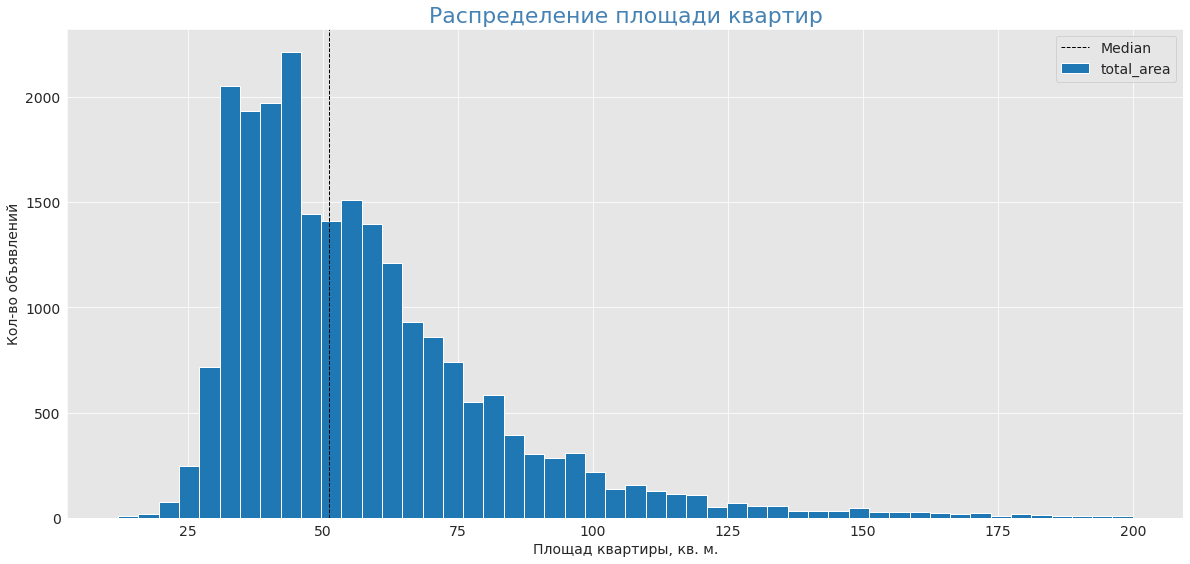

In [126]:
plot_histogram(df['total_area'], title='Распределение площади квартир', xlabel='Площад квартиры, кв. м.')

Видим, что площадь большинства объектов лежит в диапазоне от 25 до 125 кв. м. ₽, Медиана около 55 кв. м.
Распределение выглядит нормальным

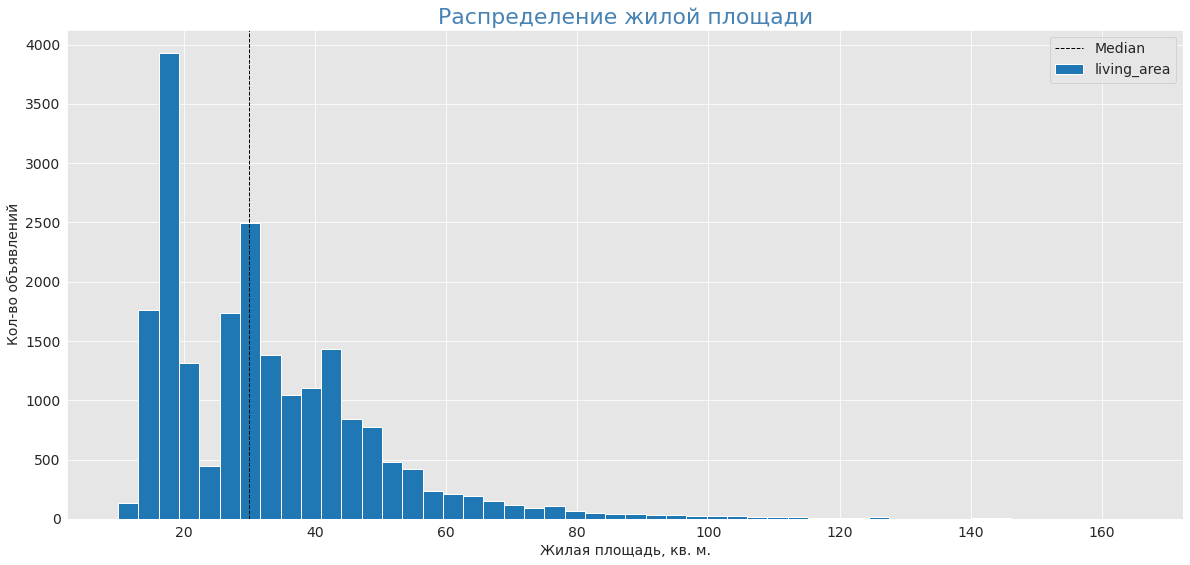

In [127]:
plot_histogram(df['living_area'], title='Распределение жилой площади', xlabel='Жилая площадь, кв. м.')

Видим, что площадь большинства объектов лежит в диапазоне от 10 до 60 кв. м.. Медиана около 30 кв. м.
Есть пики в районе около 18б 30 и 45 кв. м.
Возможно это типовая площадь квартир.

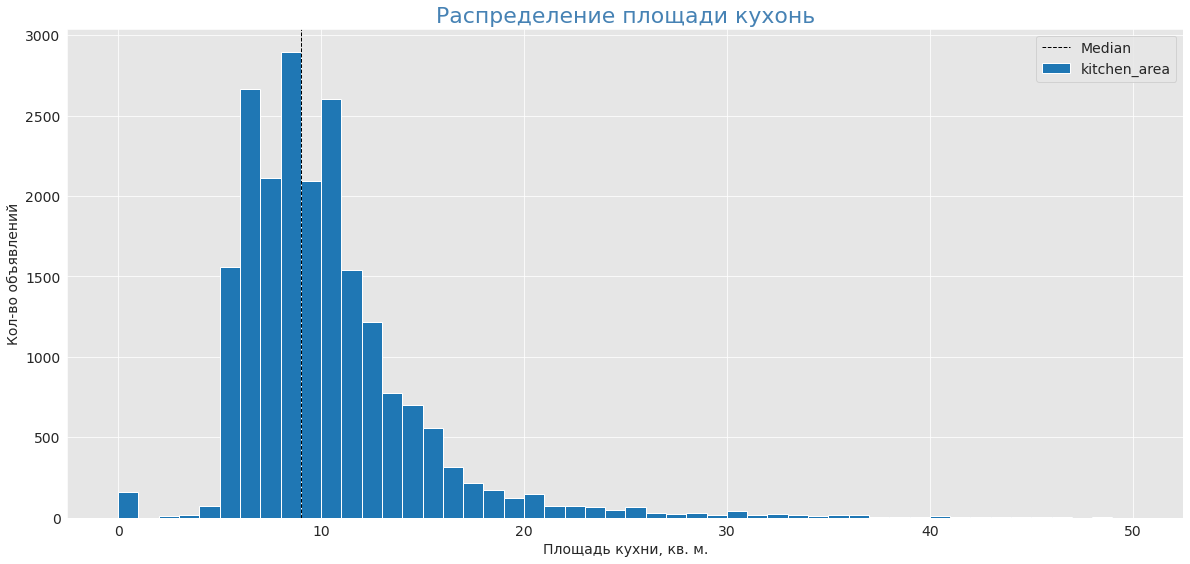

In [128]:
plot_histogram(df['kitchen_area'], title='Распределение площади кухонь', xlabel='Площадь кухни, кв. м.')

Площадь кухни лежит в диапазоне от 5 до 25 кв. м. ₽, Медиана около 9 кв. м.
Видим небольшой пик в нуле. Это может быть вызвано тем, что ранее в апартаментах и студиях мы заполняли пропуски нулями

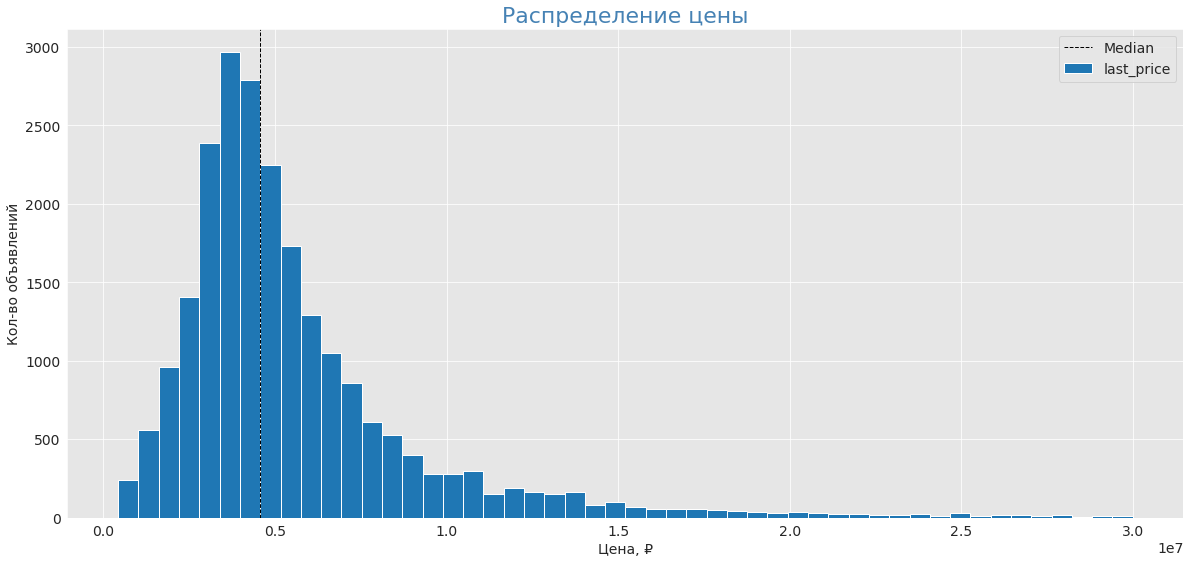

In [129]:
plot_histogram(df['last_price'], title='Распределение цены', xlabel='Цена, ₽')

Цена большинства объектов находится в пределах от 500 тыс. до 10 млн. ₽. Также есть небольшое количество более дорогих квартир
График похож на нормальное распределение

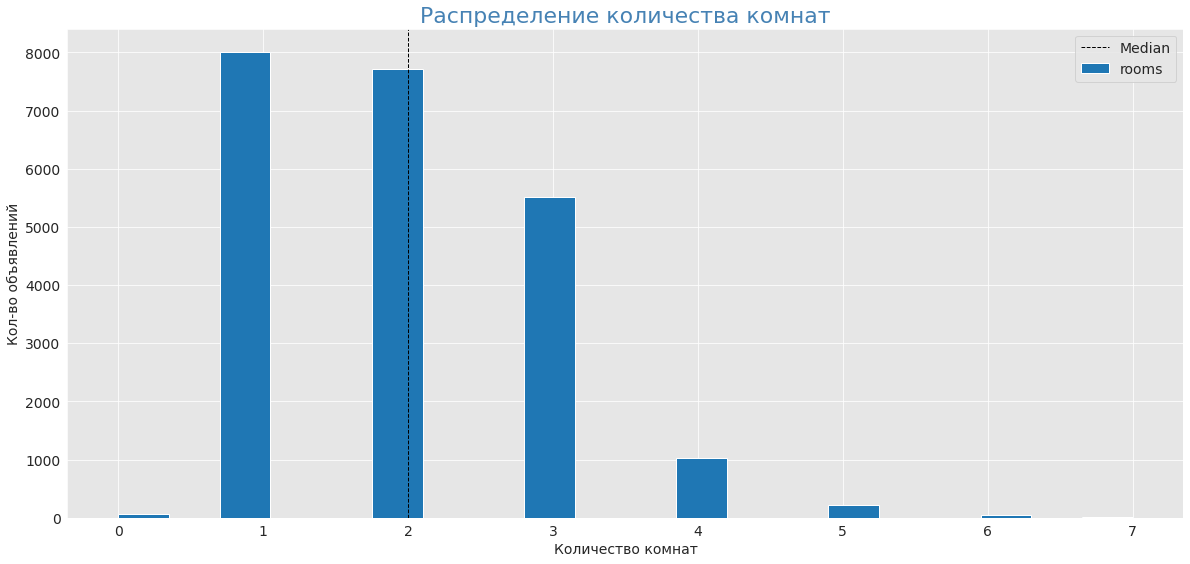

In [130]:
plot_histogram(df['rooms'], bins=20, title='Распределение количества комнат', xlabel='Количество комнат')

Судя по графику у нас нормальное распределение.
Есть небольшое количество объектов с нулём комнат. Так как у нас есть квартиры со свободной планировкой, это объяснимо

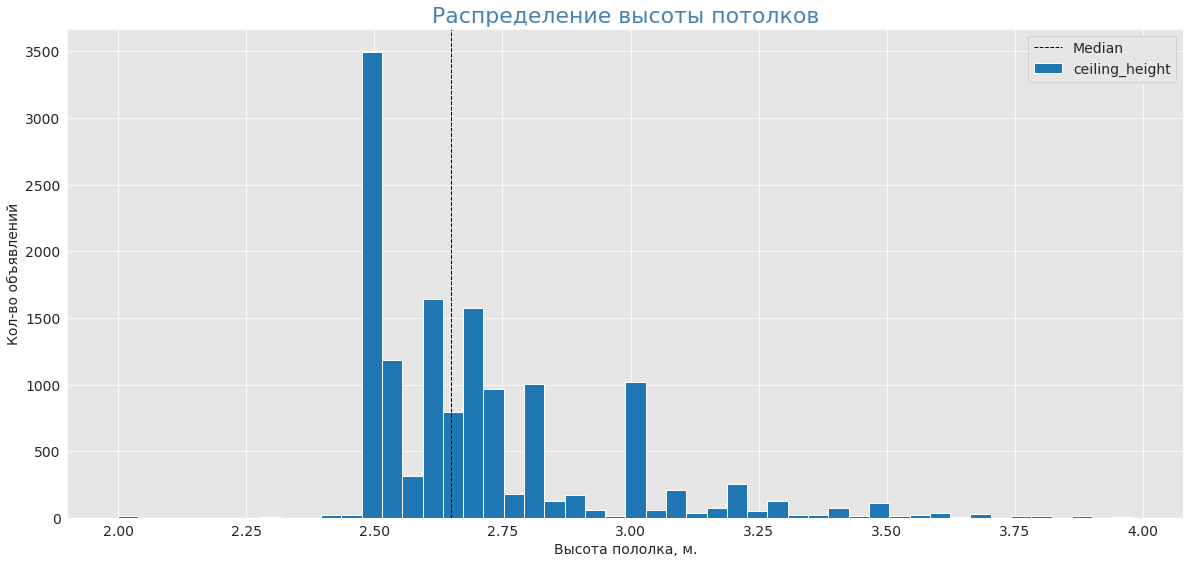

In [131]:
plot_histogram(df['ceiling_height'], title='Распределение высоты потолков', xlabel='Высота пололка, м.')

В целом, график выглядит нормльно. Большинство объектов имеет высоту потолков от 2.5 до 3 метров

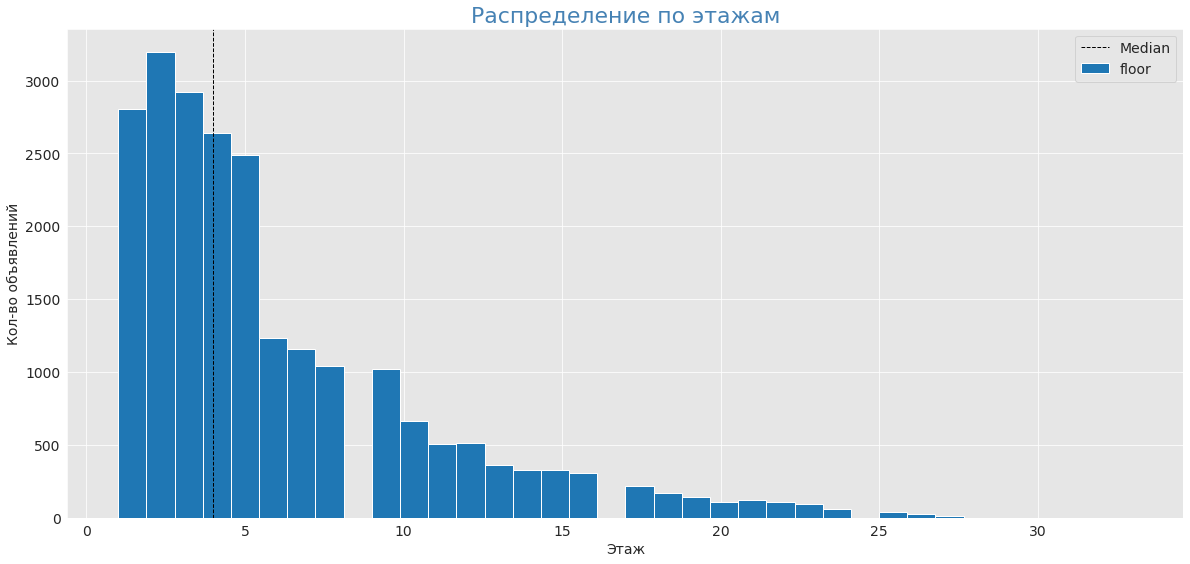

In [132]:
plot_histogram(df['floor'], bins=36, title='Распределение по этажам', xlabel='Этаж')

График соответствует нормальному распределению

Text(0, 0.5, 'Кол-во объявлений')

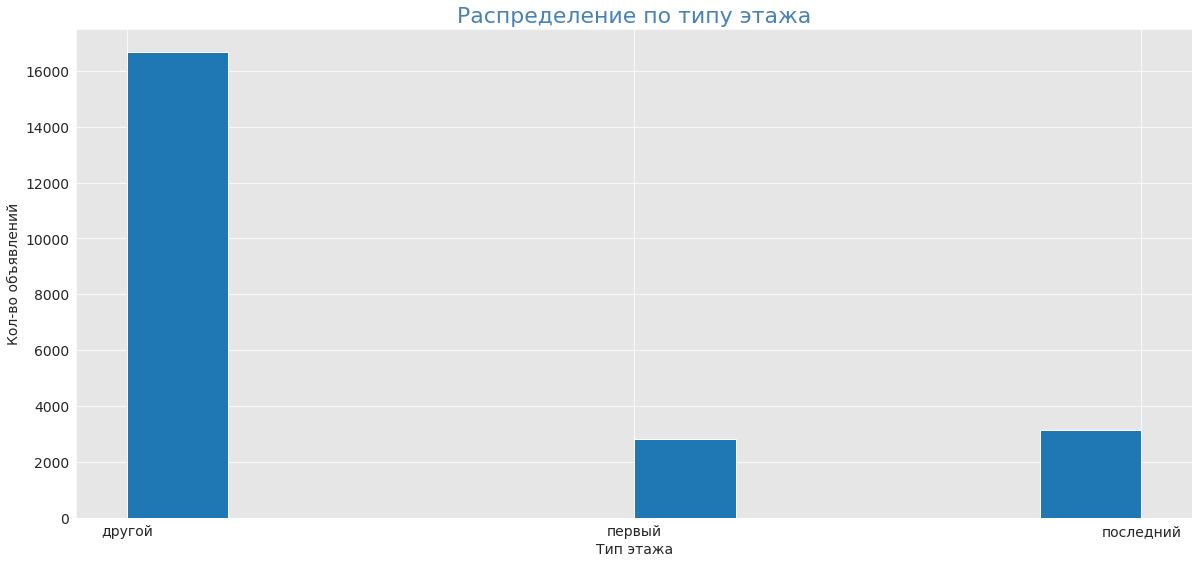

In [133]:
df['floor_type'].hist()
plt.title('Распределение по типу этажа', fontsize=22, color='SteelBlue')
plt.xlabel('Тип этажа')
plt.ylabel('Кол-во объявлений')

Большинство объектов имеют этаж с типом "другой", что логично.

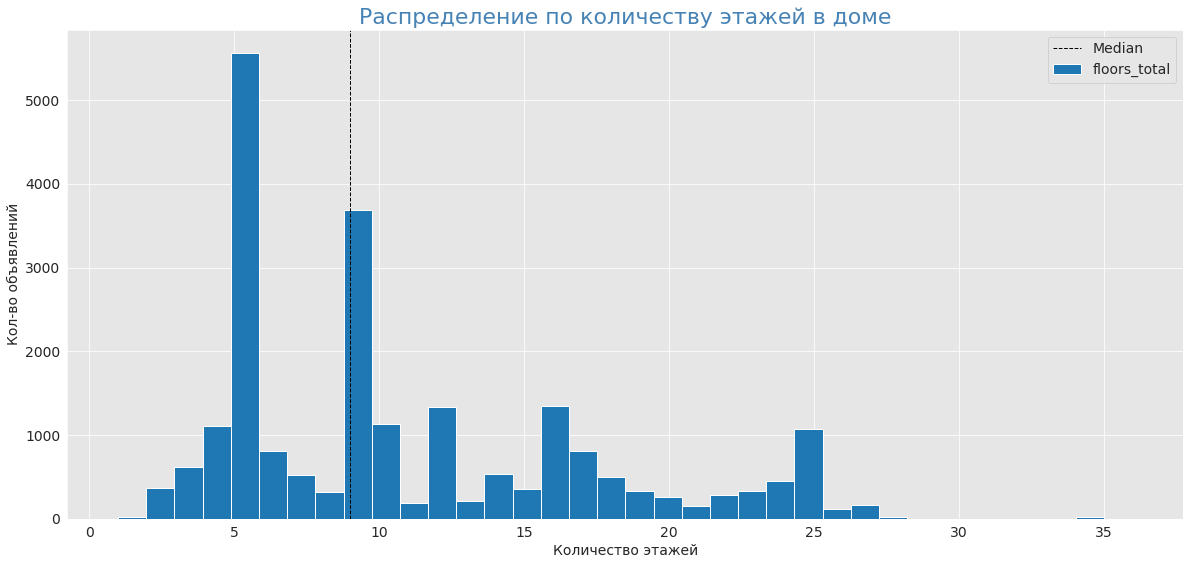

In [134]:
plot_histogram(df['floors_total'], bins=36, title='Распределение по количеству этажей в доме', 
               xlabel='Количество этажей')

По графику мы видим пики в значениях 5, 9, 12, 16 и 24
Это объясняется тем, что серии домов имеют типовую этажность

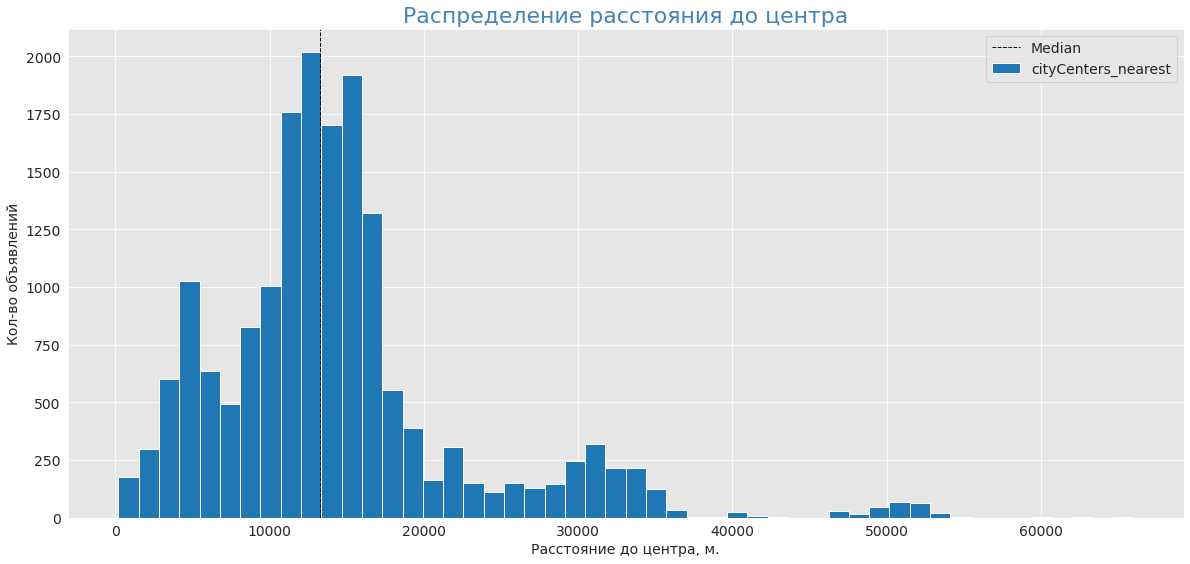

In [135]:
plot_histogram(df['cityCenters_nearest'], title='Распределение расстояния до центра', 
               xlabel='Расстояние до центра, м.')

Большая часть объектов удалена от центра не более чем на 20 км., что логично, так как большинство объектов из Санкт-Петербурга.

Также мы видим всплески в значениях около 30, 40, 50 км. Скорее всего, такие объекты расположены в активно застраиваемом пригороде, например, Кудрово, Мурино и пр.

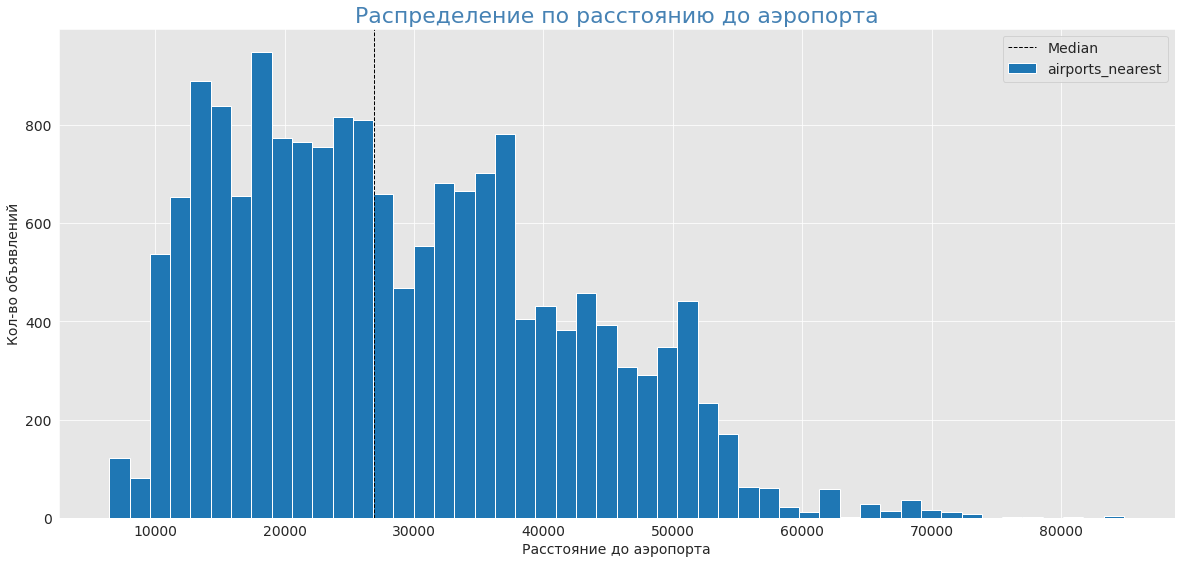

In [136]:
plot_histogram(df['airports_nearest'], title='Распределение по расстоянию до аэропорта', 
               xlabel='Расстояние до аэропорта')

Большая часть объектов лежит в диапазоне от 10 до 60 км. Распределение выглядит нормальным

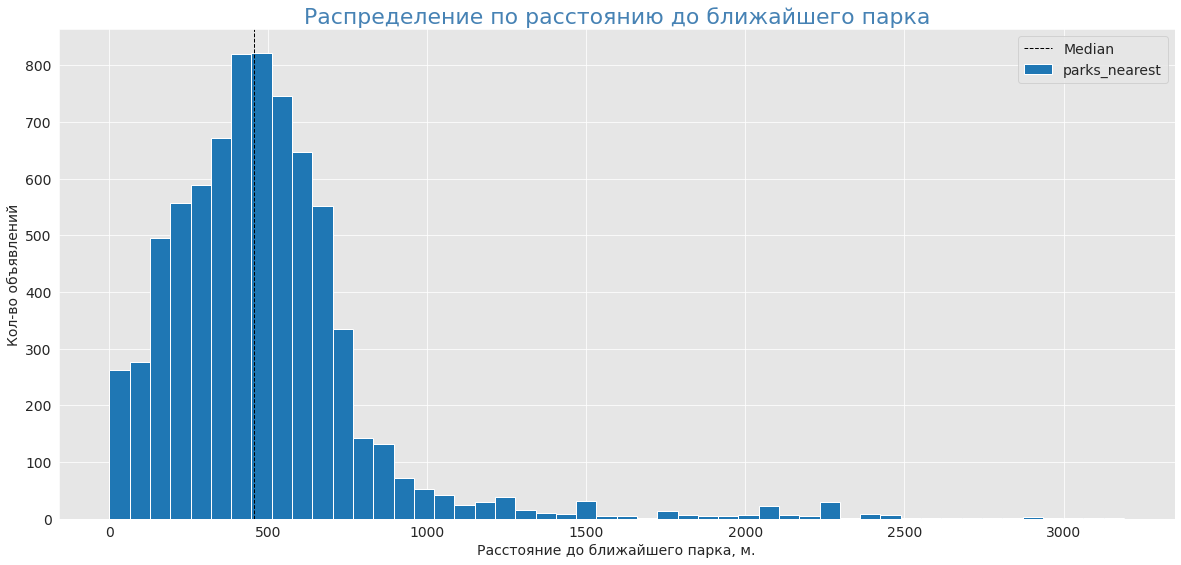

In [137]:
plot_histogram(df['parks_nearest'], title='Распределение по расстоянию до ближайшего парка', 
               xlabel='Расстояние до ближайшего парка, м.')

Большинство парков расположены на расстоянии до 1 км. 
Скорее всего, это объясняется градостроительной полтикой

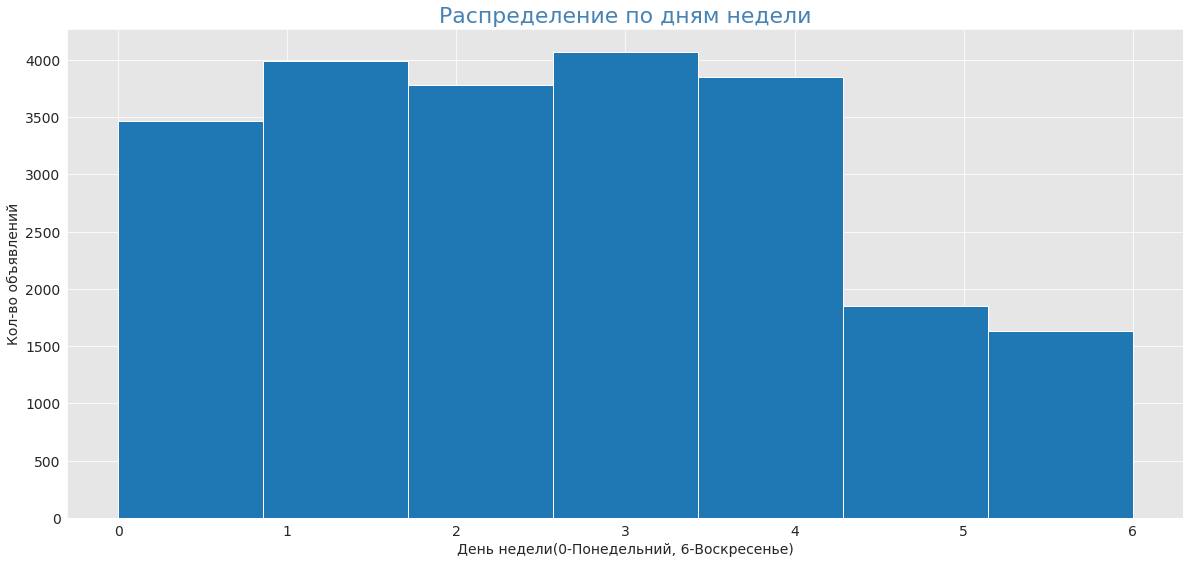

In [138]:
plot_histogram(df['day_of_week'], bins=7, median=False, title='Распределение по дням недели'
               , xlabel='День недели(0-Понедельний, 6-Воскресенье)')

По графику мы видим, что в выходные выкладывают меньшее число объявлений.
Скорее всего, большинство объявлений опубликовано риэлторами, в субботу и воскресенье у них выходные

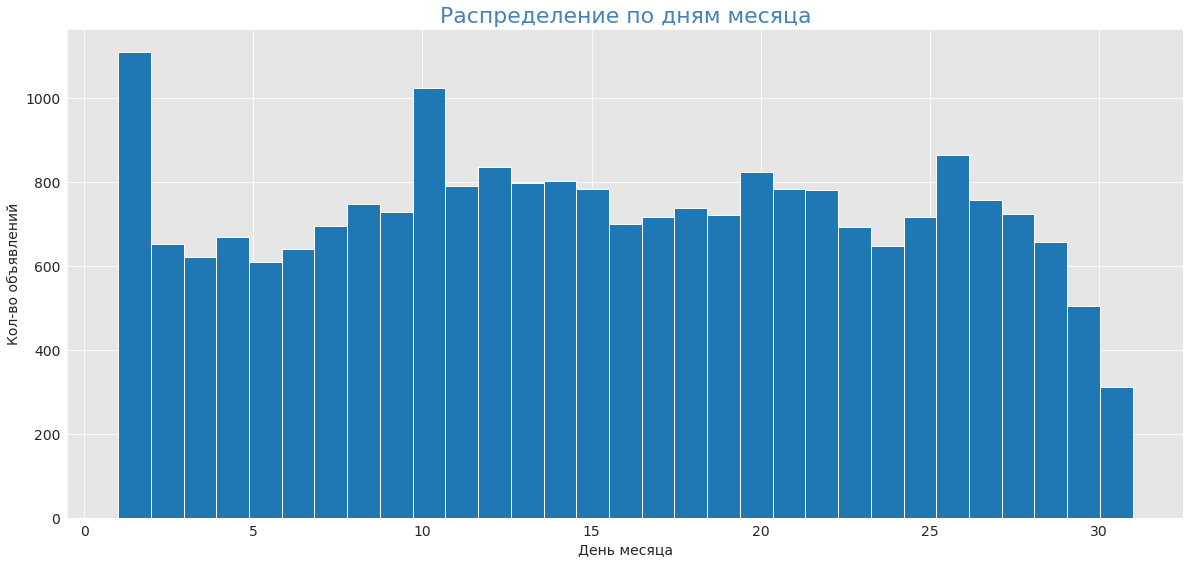

In [139]:
plot_histogram(df['first_day_exposition'].dt.day, bins=31, median=False, title='Распределение по дням месяца', 
               xlabel='День месяца')

Есть пики в районе 1 и 10. Сложно сказать, чем это вызвано.
Малое количество объявлений 30 и 31 числа связана с тем, что в половине месяцев менее 31 дня, в феврале вообще 28

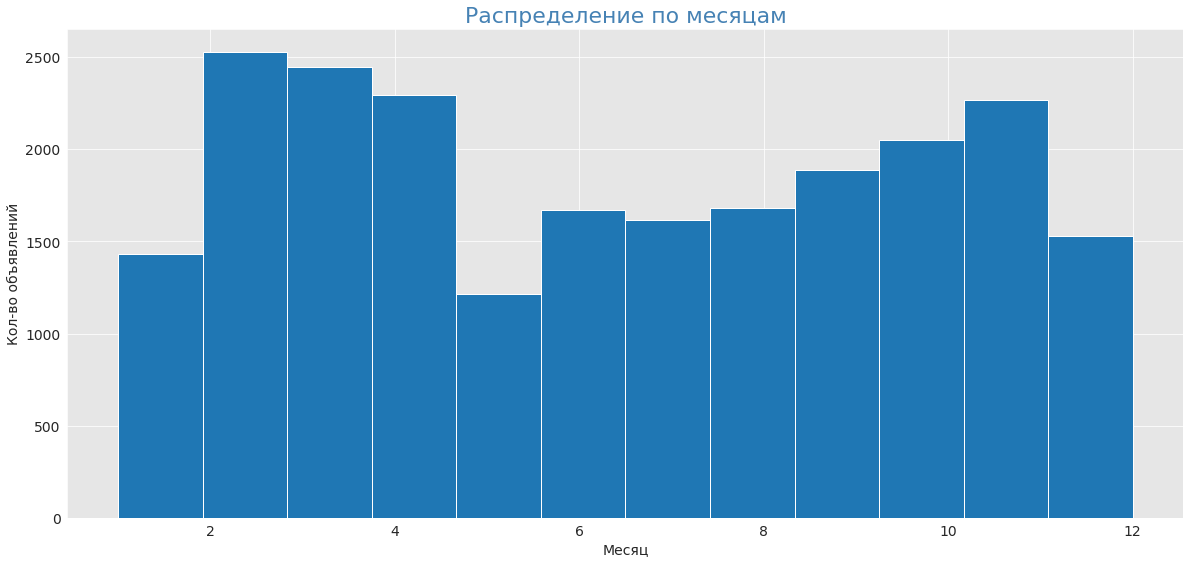

In [140]:
plot_histogram(df['month'], bins=12, median=False, title='Распределение по месяцам', 
               xlabel='Месяц')

Видим резкий спад в январе, мае и декабре. Это может быть вызвано праздниками.

#### Изучим, как быстро продавались квартиры

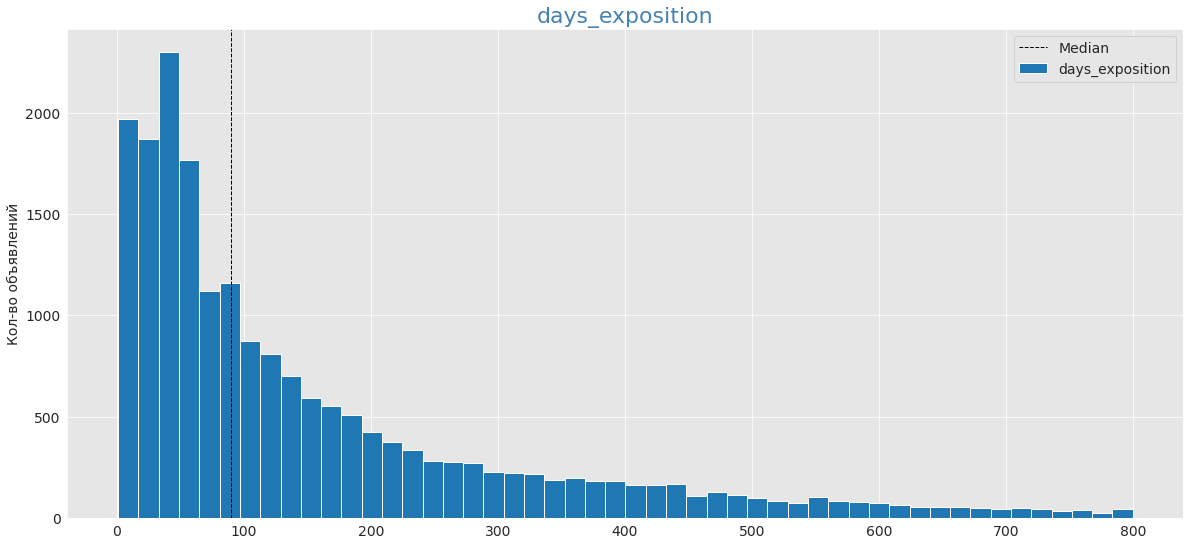

In [141]:
# построим гистограмму
plot_histogram(df['days_exposition'])

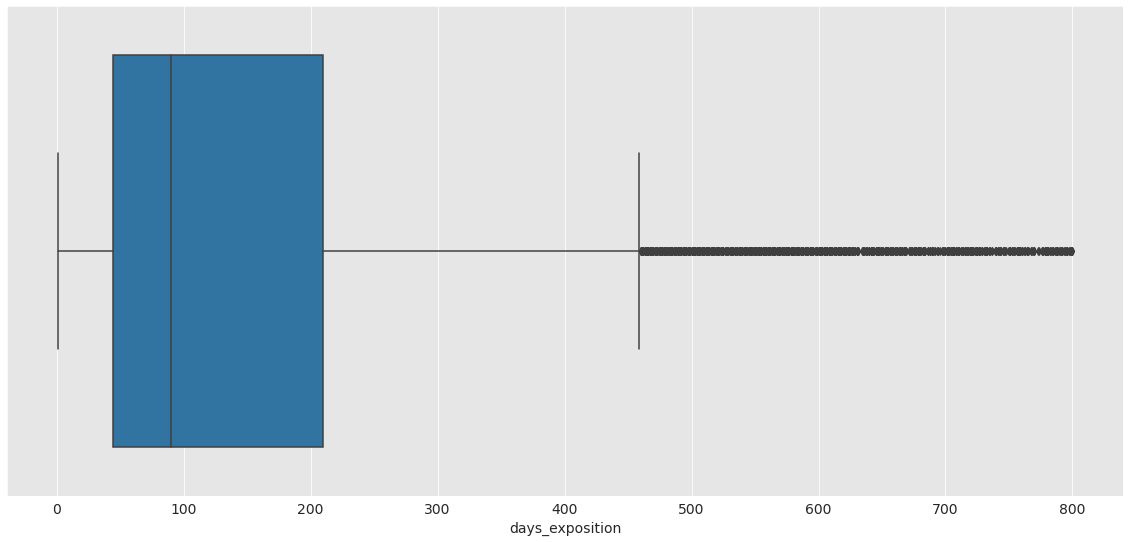

In [142]:
# построим диаграмму размаха
_ = sns.boxplot(x='days_exposition', data=df)

In [143]:
# выведем описательную статистику
df['days_exposition'].describe()

count    19570.000000
mean       154.694430
std        164.073032
min          1.000000
25%         44.000000
50%         90.000000
75%        210.000000
max        800.000000
Name: days_exposition, dtype: float64

In [144]:
# Выведем моду
int(df['days_exposition'].mode()[0])

45

По гистограмме выше видим несколько пиковых значений в пределах от 0 до 100 дней. Изучим этот период подробнее

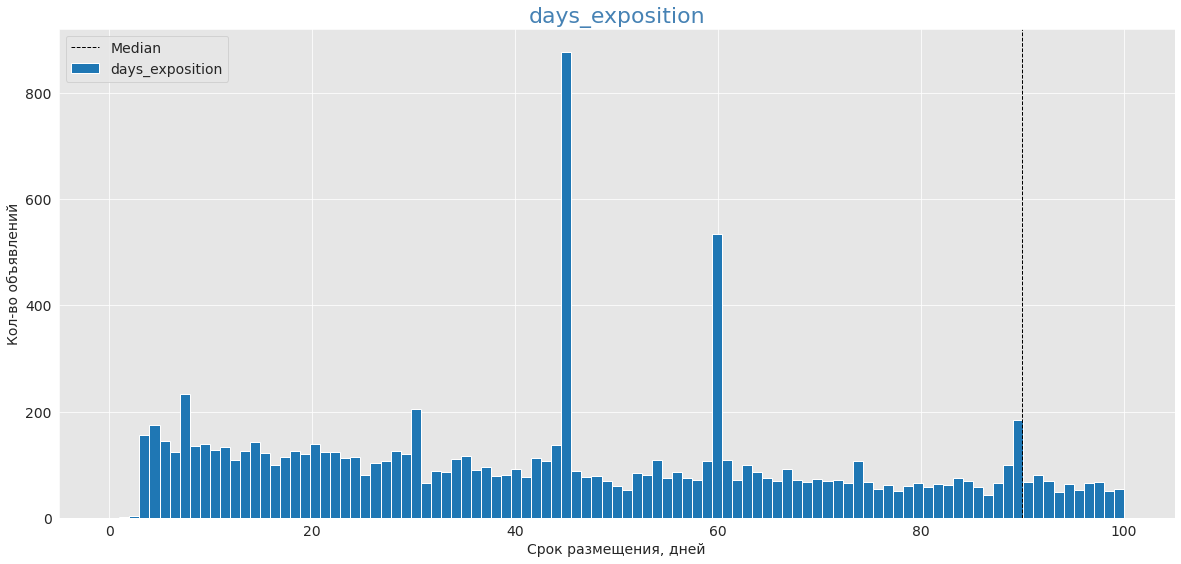

In [145]:
plot_histogram(df['days_exposition'], plt_range=(0, 100), bins=101, xlabel='Срок размещения, дней')

Продажа квартиры обычно занимает от 45 до 210 дней.

Продажи длительностью до 45 дней можно считать быстрыми.

Продажи длительностью более 450 дней можно считать необычно долгими

Наиболее частый срок размещения - 45 и 60. Также достаточно часто встречается сроки в 7, 30 и 90 дней. Это соответствует срокам публикации по условиям размещения объявлений

##### Проверим, какие факторы больше всего влияют на общую (полную) стоимость объекта

Изучим, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

In [146]:
# составим список необходимых столбцов
features=['total_area', 'living_area', 
        'kitchen_area', 'rooms', 
        'floor_type', 'day_of_week', 
        'month', 'year']

# вычислим корреляцию
corr_with_price = df[features].corrwith(df['last_price'])

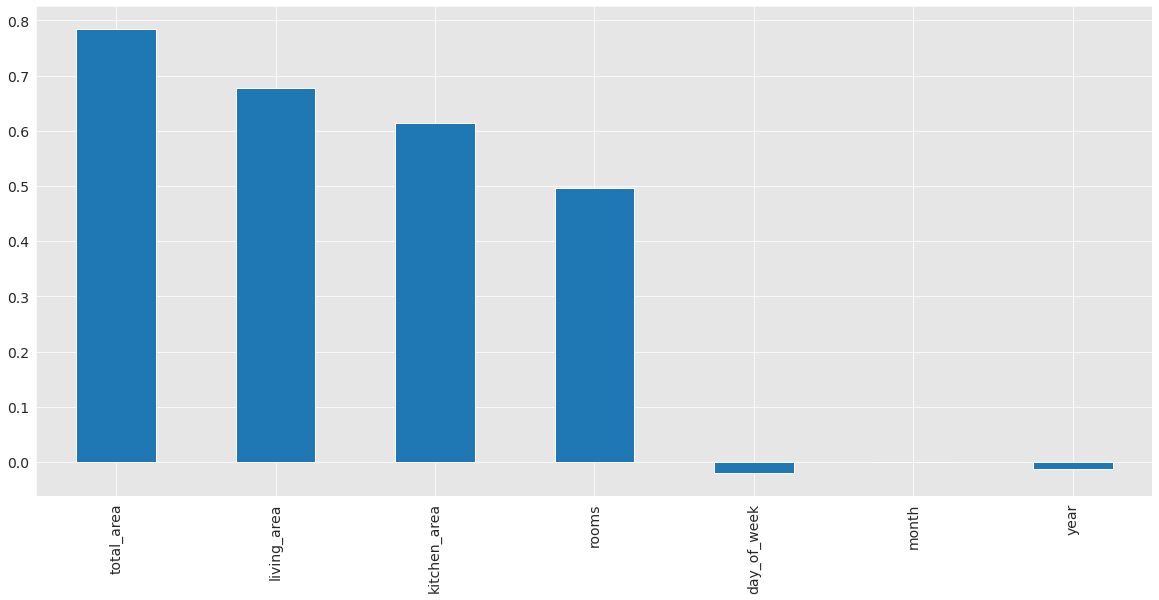

In [147]:
# построим график
_ = corr_with_price.plot(kind='bar', grid=True)

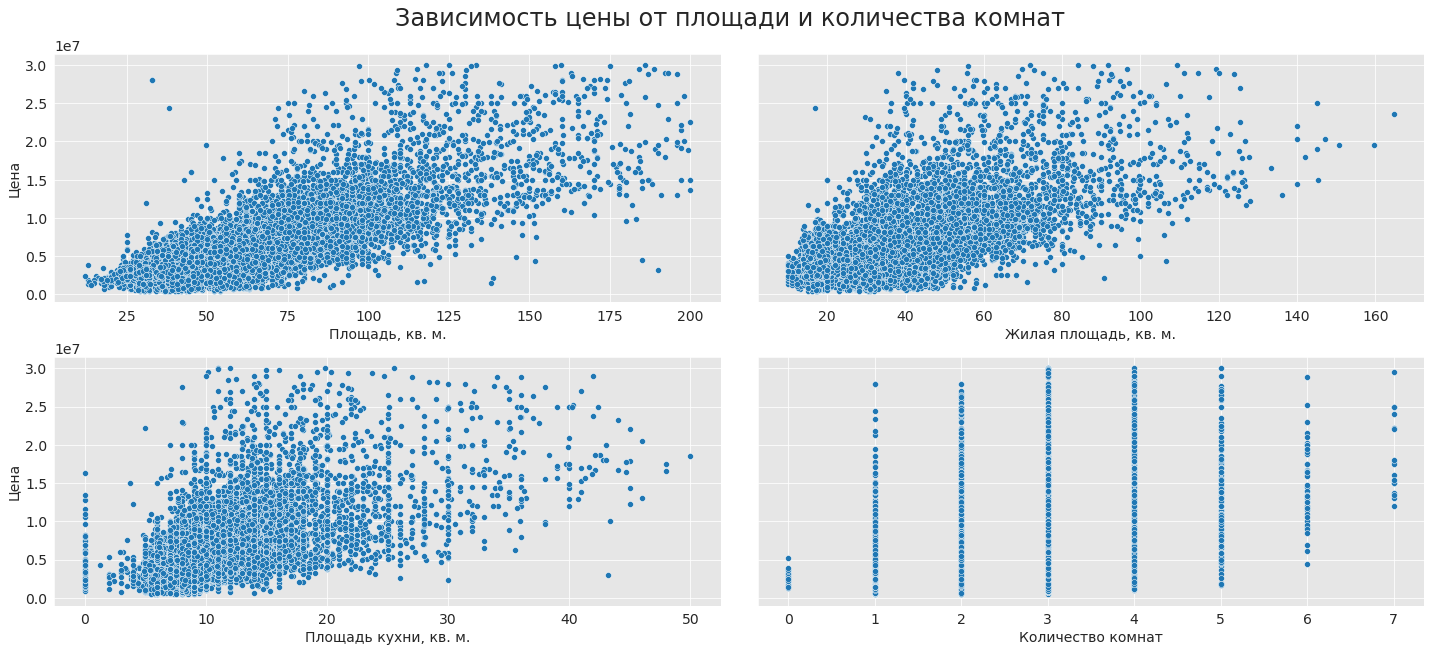

In [148]:
apt_fratures = ['total_area', 'living_area', 
        'kitchen_area', 'rooms']
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True)
fig.suptitle('Зависимость цены от площади и количества комнат', fontsize=24)
fig.tight_layout(h_pad=2)

for idx, feat in enumerate(apt_fratures):
    sns.scatterplot(data=df, x=feat, y='last_price', ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_ylabel('Цена')
    axes[idx // 2, idx % 2].set_xlabel(column_names_dict[feat])

Text(0.5, 0, 'Тип этажа')

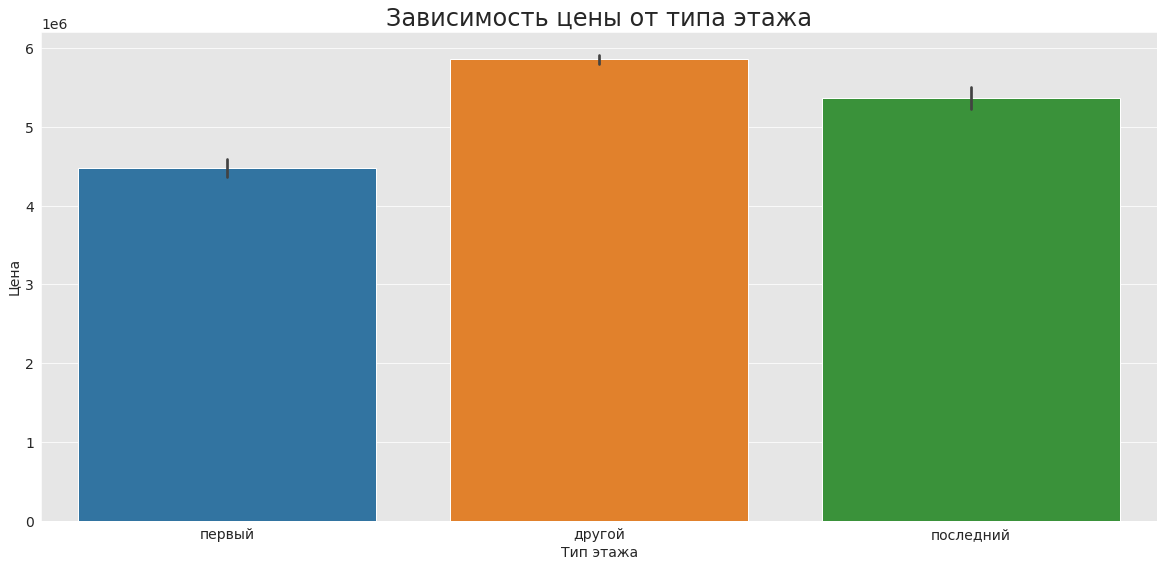

In [149]:
sns.barplot(data=df, x='floor_type', y='last_price', order=['первый', 'другой', 'последний'])
plt.title('Зависимость цены от типа этажа', fontsize=24)
plt.ylabel('Цена')
plt.xlabel(column_names_dict['floor_type'])

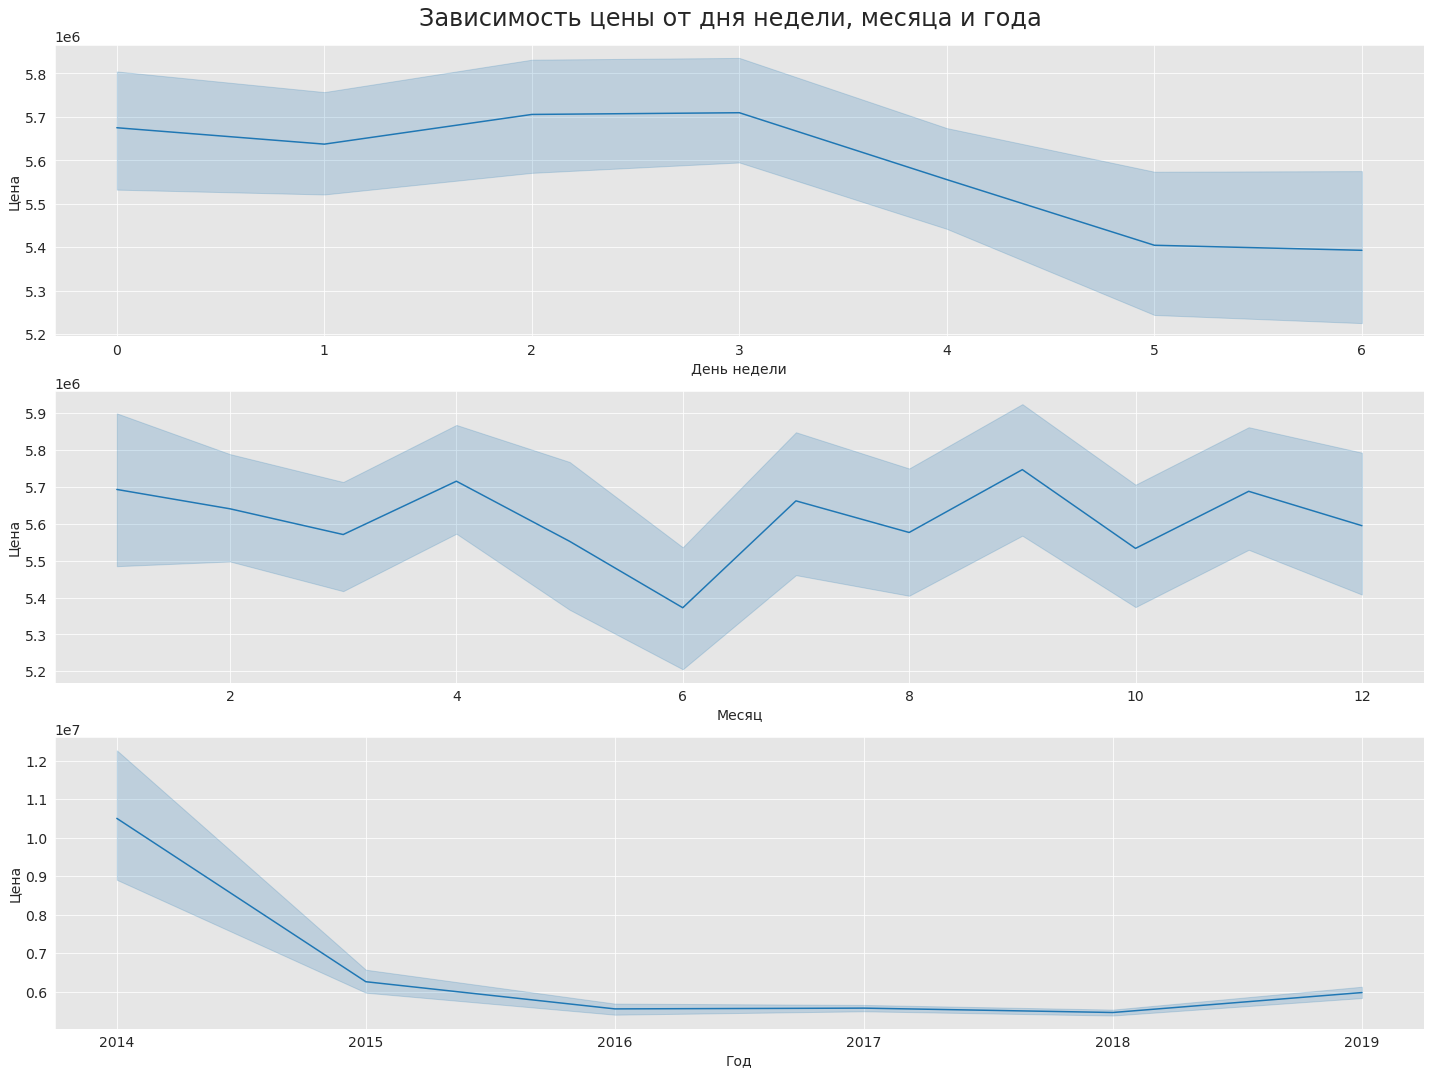

In [150]:
date_features = ['day_of_week', 
        'month', 'year']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
fig.suptitle('Зависимость цены от дня недели, месяца и года', fontsize=24)
fig.tight_layout(h_pad=2)

for idx, feat in enumerate(date_features):
    sns.lineplot(data=df, x=feat, y='last_price', ax=axes[idx])
    axes[idx].set_ylabel('Цена')
    axes[idx].set_xlabel(column_names_dict[feat])

Видим, что цена больше всего зависит от следующих параметров(в порядке убывания):
- Общая площадь
- Жилая площадь
- Площадь кухни
- Количество комнат

На графиках видно прямую зависимость от размера квартиры(площади и количества комнат)

Больше всего ценятся квартиры между первым и последним этажом. Меньше всего - на первом.

В объявлениях, опубликованных в субботу и воскресенье цена ниже, чем в будние дни.

Самая низкая цена наблюдается в объявлениях, опубликованных в июне. В остальные месяцы цена меняется незначительно

После 2014 заметно резкое падение цены, далее наблюдалось незначительное падение до 2016 года. В 2019 году заметен небольшой рост цены.


##### Посчитаем среднюю цену квадратного метра в в 10 населённых пунктах с наибольшим числом объявлений

In [151]:
# check TOP-10

mean_sqr_meter_table_top10 = (
    df
    .groupby('locality_name')['one_sqr_meter_price']
    .agg({'count', 'mean'})
    .sort_values(by = 'count', ascending = False)
    .head(10)    
).sort_values(by = 'mean', ascending = False)

mean_sqr_meter_table_top10.style.format("{:,.0f}")

,count,mean
locality_name,,
Санкт-Петербург,"14,874","110,358"
Пушкин,351,"102,599"
деревня Кудрово,290,"92,521"
поселок Парголово,321,"90,235"
поселок Мурино,542,"85,794"
поселок Шушары,433,"78,601"
Колпино,333,"75,275"
Гатчина,297,"68,976"
Всеволожск,387,"68,590"


In [152]:
#Рассчитаем среднюю цену квадратного метра в 10 городах с наибольшим количеством обявлений
'{0:.1f}'.format(mean_sqr_meter_table_top10['mean'].mean())

'83122.9'

Построим график

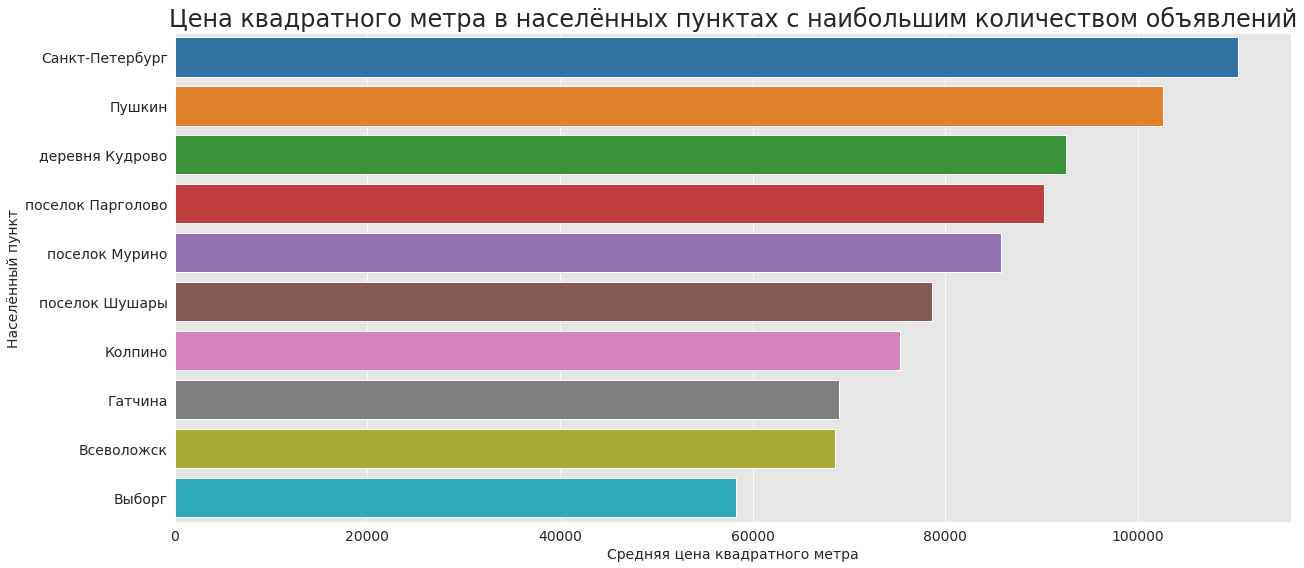

In [153]:
sns.barplot(x='mean', y=mean_sqr_meter_table_top10.index, data=mean_sqr_meter_table_top10)
plt.title('Цена квадратного метра в населённых пунктах с наибольшим количеством объявлений',
         fontsize=24)
plt.xlabel('Средняя цена квадратного метра')
_ = plt.ylabel('Населённый пункт')

Среди 10 городов с наибольшим количеством объявлений:
- Самая высокая средняя цена квадратного метра в Санкт-Петербурге: 110 358₽ 
- Самая низкая - в Выборге: 58 2808

##### Проверим, как зависит цена от расстояния до центра города для квартир в Санкт-Петербурге

In [154]:
# сгруппируем данные по расстоянию до центра, посчитаем среднюю цену объекта и квадратного метра
df[df['locality_name'] == 'Санкт-Петербург'].pivot_table(index='cityCenters_nearest_km', 
                                                         values=['last_price', 'one_sqr_meter_price'],
                                                        aggfunc='mean').astype('int64')

,last_price,one_sqr_meter_price
cityCenters_nearest_km,,
0.0,11290769,116000
1.0,11528846,143639
2.0,10641652,127617
3.0,9591899,116892
4.0,10128809,125026
5.0,10545888,131737
6.0,9325129,131179
7.0,9200347,131141
8.0,8649700,122854


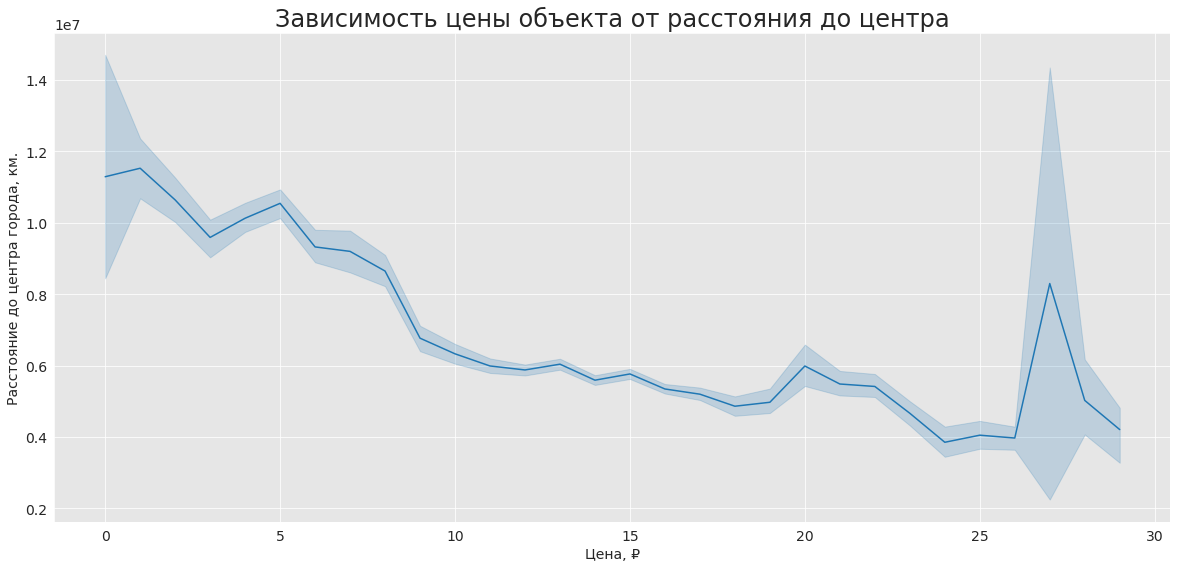

In [155]:
# построим график зависимости цены объекта от расстояния до центра для Санкт-Петербурга
sns.lineplot(
    x='cityCenters_nearest_km', 
    y='last_price', 
    data=df[df['locality_name'] == 'Санкт-Петербург']
)
plt.title('Зависимость цены объекта от расстояния до центра',
         fontsize=24)
plt.xlabel(column_names_dict['last_price'])
_ = plt.ylabel(column_names_dict['cityCenters_nearest_km'])

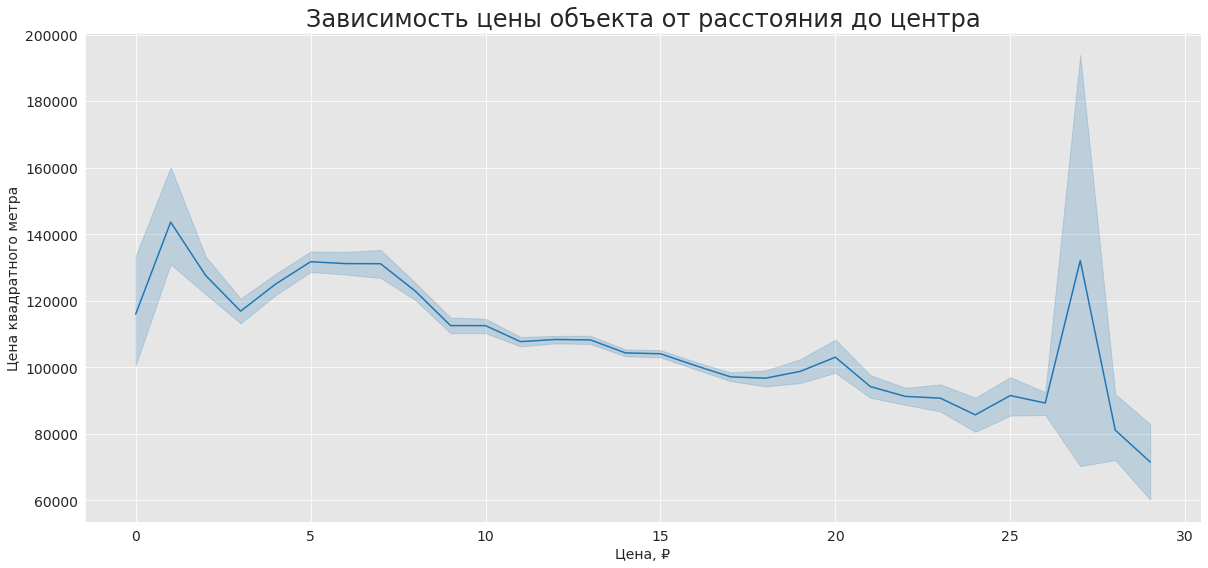

In [156]:
# построим график зависимости цены квадратного метра от расстояния до центра для Санкт-Петербурга
sns.lineplot(
    x='cityCenters_nearest_km', 
    y='one_sqr_meter_price', 
    data=df[df['locality_name'] == 'Санкт-Петербург']
)
plt.title('Зависимость цены объекта от расстояния до центра',
         fontsize=24)
plt.xlabel(column_names_dict['last_price'])
_ = plt.ylabel(column_names_dict['one_sqr_meter_price'])

Видим пик в районе 27 км. Найдем такие объекты

In [157]:
df[(df['locality_name'] == 'Санкт-Петербург') & (df['cityCenters_nearest_km'] == 27)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,new_loacality_name,one_sqr_meter_price,day_of_week,month,year,floor_type,cityCenters_nearest_km
748,13,14350000,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,0,NaN,128.0,Санкт-Петербург,193918,1,11,2017,другой,27.0
5961,6,2250000,32.0,2018-02-27,1,NaN,2,16.5,2,False,...,0,NaN,178.0,Санкт-Петербург,70312,1,2,2018,последний,27.0


В целом, видим, что с увеличение расстояния снижается общая цена и цена квадратного метра.
Выброс на 27 км. вызван малым количеством объектов.

### Общий вывод

In [158]:
# посчитем, сколько объектов являются апартаментами, студиями и квартирами со свободной планировкой
df[['is_apartment', 'studio', 'open_plan']].sum()

is_apartment     40
studio          143
open_plan        65
dtype: int64

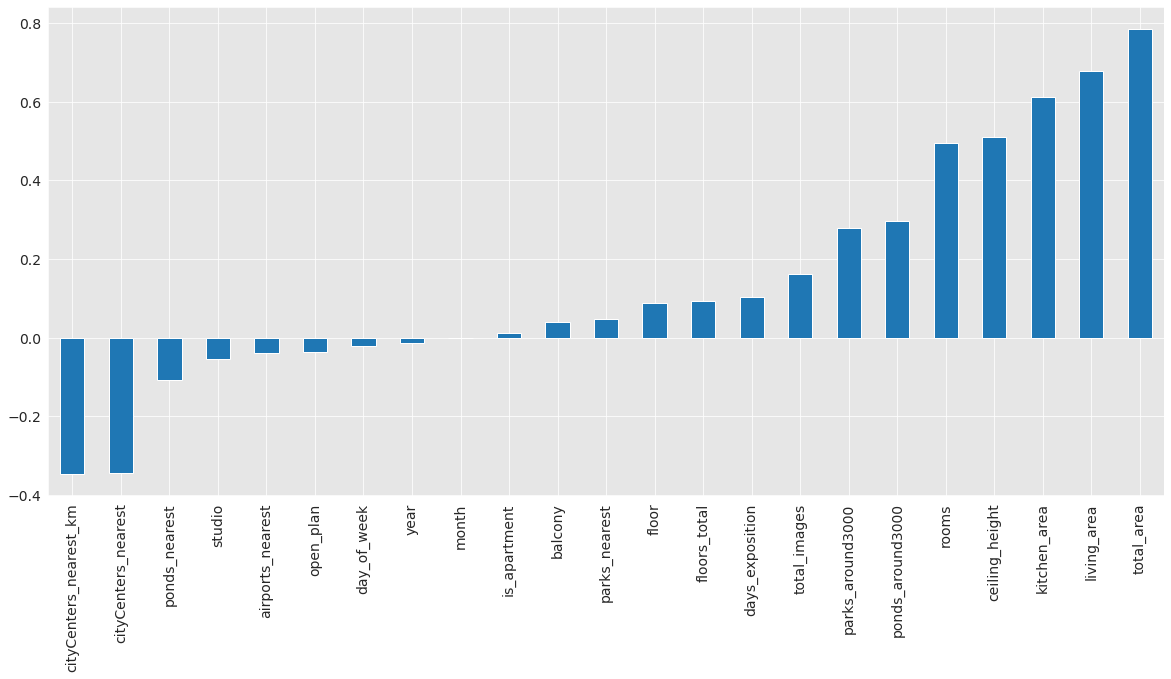

In [159]:
# построим корреляцию цены с остальными параметрами
_ = df[df.columns.drop(['last_price', 'one_sqr_meter_price'])].corrwith(df['last_price']).sort_values().plot(kind='bar', grid=True)

В ходе исследования было проанализировано 22627 объявление о продаже квартир в Санкт-Петербурге и ближайших городах за 2014-2019 год

Большинство объектов находятся в Санкт-Петербурге

Среди объектов есть:
- 40 апартаментов
- 143 студии
- 65 квартиры со свободной планировкой

Остальные объекты - обычные квартиры

###### Средняя квартира обладает следующими параметрами:
- площадь от 40 до 70 кв. м., медиана -50
- жилая площадь от 18 до 40 кв. м.
- площадь кухни от 7 до 12 кв. м.. Среди объектов есть аппартаменты и студии, в которых может не быть отдельной кухни.
- высота потолков от 2.5 до 2.8 м.
- этаж от 2 до 8
- количество этажей в доме от от 5 до 16
- располагается между первым и последним этажом
- нет балконов
- расстояние до центра от 10 до 16 км
- расстояние до аэропорта от 18 до 37 км
- для большинства квартир нет парков и прудов в пределах 3 км. При наличии среднее расстояние:
 - до ближайшего парка от 300 до 600 м.
 - до ближайшего пруда от 300 до 700 метров
- цена квартиры от 3.4 до 6.5 млн. ₽
- цена квадратного метра от 76 тыс до 111 тыс


Во время выходных, а также в январе, мае и декабре публикуют меньше объявлений.

Продажа квартиры обычно занимает от 45 до 210 дней.

Продажи длительностью до 45 дней можно считать быстрыми.

Продажи длительностью более 450 дней можно считать необычно долгими

Ниболее сильно цена квартиры зависит от:
- площади(общей, жилой и кухни)
- количества комнат
- высоты пололков
- расстояния до центра(при удалении от центра цена снижается)

Цена наименее зависит от
- количества балконов
- расстояния до аэропорта
- дня недели, месяца, года публикации


Больше всего ценятся квартиры между первым и последним этажом. Меньше всего - на первом.

В объявлениях, опубликованных в субботу и воскресенье цена ниже, чем в будние дни.

После 2014 заметно резкое падение цены, далее наблюдалось незначительное падение до 2016 года. В 2019 году заметен небольшой рост.
